# Predcition of Hospital Admission Related to Otitis Externa

In this notebook, we develop Cox proportional hazard regression models to predict the risk of hospital admission related to otitis externa (ot_externa).

In [1]:
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.preprocessing import OneHotEncoder
from datetime import date
from operator import attrgetter
import io
from contextlib import redirect_stdout
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

## 0- functions

In [2]:
#function to transform cph model summary and save it as html
def GetPrintSummary(model):
    output = ""
    with io.StringIO() as buf, redirect_stdout(buf):
        model.print_summary(style="html")
        output = buf.getvalue()
    return output

In [3]:
#round counts in a way that the last digit become 0 or 5
def round_five_mul(x, base=5):
    return base * round(x/base)

In [4]:
#function to process infection data 
def proc_infec_data(data, i):
    datum = data
    datum = datum[['age', 'age_cat', 'sex', 'flu_vaccine', 'smoking_status', 'bmi', 'imd', 'ethnicity', 
                   'region', 'CCI', 'died_date', 'deregistered_date', 'practice', 
                   'antibacterial_brit_'+str(i), 'ot_externa_date_'+str(i), 'ot_externa_ab_date_'+str(i), 'ot_externa_ab_type_'+str(i),
                   'incdt_ot_externa_date_'+str(i), 'admitted_ot_externa_date_'+str(i), 'sgss_gp_cov_ot_externa_date_'+str(i)]]
    
    #drop rows with no ot_externa reord
    datum = datum[datum['ot_externa_date_'+str(i)].notnull()]
    #exclusion of covid positive 90 days before and 30 days after dx with ot_externa_i
    datum = datum[datum['sgss_gp_cov_ot_externa_date_'+str(i)] == 0]
    #rename variables with i
    datum.rename(columns={'ot_externa_date_'+str(i): 'ot_externa_date', 'ot_externa_ab_date_'+str(i): 'ot_externa_ab_date', 
                           'ot_externa_ab_type_'+str(i): 'ab_type', 'antibacterial_brit_'+str(i): 'antibacterial_brit',
                           'incdt_ot_externa_date_'+str(i): 'incdt_ot_externa_date', 'incdt_ot_externa_type_'+str(i): 'incdt_ot_externa_type',
                           'admitted_ot_externa_date_'+str(i): 'admitted_ot_externa_date',
                           'sgss_gp_cov_ot_externa_date_'+str(i): 'sgss_gp_cov_ot_externa_date'},
                inplace=True)
    
    return datum

In [5]:
#preparation of data for cox models
def cox_data_prep(data, vars, vars_countinuous, vars_output):
    data_req = data[vars+vars_countinuous+vars_output]
    #encoding categorical data for cox models
    data_enc = data_req[vars+vars_countinuous].reset_index()
    #creating instance of one-hot-encoder
    enc = OneHotEncoder()
    data_req_enc = pd.DataFrame(enc.fit_transform(data_enc[vars]).toarray())
    data_req_enc.columns = enc.get_feature_names(data_enc[vars].columns)
    data_req_enc = data_enc[vars_countinuous].join(data_req_enc) 

    return data_req, data_req_enc

In [6]:
#summary table of observation counts
def make_summary_table(infection, infection_type, data):
    summary_table = data.sum(axis=0).reset_index()
    summary_table.columns = ['variable', 'count']
    #round count to make last digit either 0 or 5
    summary_table['mean'] = data.mean(axis=0).reset_index()[0]
    summary_table['count'] = round_five_mul(summary_table['count'], base=5)
    summary_table['std'] = data.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table.loc[(summary_table['count'] <= 5), 'count'] = 'SM'

    # save table
    summary_table.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'.csv', index=False)

In [7]:
#summary table of hospitalised cases
def make_summary_table_hosped(infection, infection_type, data):
    #keep hospitalised cses (events=1)
    data_hosped = data[data['event_'+infection+'_admitted'] == 1]

    #encoding categorical hosped data
    data_hosped = data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period', 'antibacterial_brit']].reset_index()

    #creating instance of one-hot-encoder
    enc = OneHotEncoder()
    data_hosped_enc = pd.DataFrame(enc.fit_transform(data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period']]).toarray())
    data_hosped_enc.columns = enc.get_feature_names(data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period']].columns)
    data_hosped_enc = data_hosped[['antibacterial_brit']].join(data_hosped_enc)

    #summary table for hosped cases
    summary_table_hosped = data_hosped_enc.sum(axis=0).reset_index()
    summary_table_hosped.columns = ['variable', 'count']
    summary_table_hosped['mean'] = data_hosped_enc.mean(axis=0).reset_index()[0]
    #round count to make last digit either 0 or 5
    summary_table_hosped['count'] = round_five_mul(summary_table_hosped['count'], base=5)
    summary_table_hosped['std'] = data_hosped_enc.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table_hosped.loc[(summary_table_hosped['count'] <= 5), 'count'] = 'SM'

    #save table
    summary_table_hosped.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'_hosped.csv', index=False)

In [8]:
#build cox models
def cox_model_build(infection, infection_type, data): 
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #calculate and save ci
    ci = cph.concordance_index_
    a = open('../output/hospitalisation_prediction_'+infection+'/'+infection+'_'+infection_type+'_ci.txt', "w")
    a.write("")
    a.writelines(['Concordance index for '+infection+'_'+infection_type+' with development data: %.4f' % (ci)])

    return cph, data_train, data_test

In [9]:
#save coefficients (betas) and calculate sum of betas
def cox_betas_sumbetas_calculate(cph, directory, betas_name, data_infection_enc, data_infection, sum_betas_name):
    # cleaning up covariates to make them compatible with the encoded data
    covariates = cph.params_.reset_index()#.hazard_ratios_
    covariates.covariate = covariates.covariate.str.replace("[","")
    covariates.covariate = covariates.covariate.str.replace("]","")
    covariates.covariate = covariates.covariate.str.replace("T.","_")
    #save coefficients
    covariates.to_csv(directory+betas_name, index=False)

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv(directory+'hazard_ratios_'+betas_name, index=False)

    #transpose and sort covariates and coefficients
    covariatesT = covariates.T
    header = covariatesT.iloc[0]
    covariatesT = covariatesT[1:]
    covariatesT.columns = header
    covariatesT = covariatesT.sort_index(axis = 1) #sort covariates to match data

    #further cleaning up covariates to make them compatible with the encoded data
    covariates_list = ["'" + item + "'" for item in covariates.covariate] #adds single quotation mark
    covariates_list = [value.replace("'", "") for value in covariates_list] #removes double quotation mark 

    #match covariates_list (covariates of cox model) with encoded data
    data = data_infection_enc[data_infection_enc.columns.intersection(covariates_list)] 
    data = data.sort_index(axis = 1) #sort 

    #multiply betas and encoded data
    betas = data.multiply(np.array(covariatesT), axis='columns')

    #sum up betas of each row to calculate sum of betas 
    sum_betas = betas.sum(axis=1)
    
    #predict cumulative hazard values at day 30 and match them with sum of betas
    sum_betas_hazard = cph.predict_cumulative_hazard(data_infection).loc[[30]].T.reset_index(drop=True)
    sum_betas_hazard['sum_betas'] = sum_betas

    #drop rows with predicted risks greater than 99th percentile of all risks
    sum_betas_hazard = sum_betas_hazard[sum_betas_hazard[30] <= sum_betas_hazard[30].quantile(0.99)]  

    #sort values of sum of betas
    sum_betas_hazard = sum_betas_hazard.sort_values(by=['sum_betas'])

    # binning sum of betas into 100 bins
    sum_betas_hazard['bins'] = pd.cut(sum_betas_hazard['sum_betas'], 100) #100 intervals between min and max of sum_betas

    #calculate mean of cumulative hazar at day 30 by groupby 
    sum_betas_hazard_groupby = sum_betas_hazard.groupby(['bins'])[30.0].describe().reset_index()

    #calculate interpolation of missing mean values 
    sum_betas_hazard_groupby['mean_interpolate'] = sum_betas_hazard_groupby['mean'].interpolate(method='linear')

    #separate upper and lower boundries of bins
    sum_betas_hazard_groupby['bin_lower'] = sum_betas_hazard_groupby['bins'].map(attrgetter('left'))
    sum_betas_hazard_groupby['bin_upper'] = sum_betas_hazard_groupby['bins'].map(attrgetter('right'))

    #select relevant columns including mean of cumulative hazard for each bin and the interpolation of means of cumulative hazard
    sum_betas = sum_betas_hazard_groupby[['bin_lower', 'bin_upper', 'mean_interpolate']]

    #save relevant columns of sum_betas
    sum_betas.to_csv(directory+sum_betas_name, index=False)

In [10]:
def cox_roc_curve(cph, event_col_name, data_train, data_test, directory, roc_name):
    #analysis of discrimination (training) by calculating cumulative hazard at day 30 and comparing it with variable event  
    cph_train_cumulative_hazard = cph.predict_cumulative_hazard(data_train)
    cph_train_cumulative_hazard = cph_train_cumulative_hazard.loc[[30]].T
    cph_train_cumulative_hazard[event_col_name] = data_train[event_col_name]
    cph_train_cumulative_hazard = cph_train_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)

    #analysis of discrimination (testing) by calculating cumulative hazard at day 30 and comparing it with variable event  
    cph_test_cumulative_hazard = cph.predict_cumulative_hazard(data_test)
    cph_test_cumulative_hazard = cph_test_cumulative_hazard.loc[[30]].T
    cph_test_cumulative_hazard[event_col_name] = data_test[event_col_name]
    cph_test_cumulative_hazard = cph_test_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)

    #plot roc curves
    r_fpr1, r_tpr1, _ = roc_curve(cph_train_cumulative_hazard[event_col_name], cph_train_cumulative_hazard.cumulative_hazard)
    r_fpr2, r_tpr2, _ = roc_curve(cph_test_cumulative_hazard[event_col_name], cph_test_cumulative_hazard.cumulative_hazard)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line1, = plt.plot(r_fpr1, r_tpr1, linestyle='-', marker='o', markersize=6, markevery=0.1, color='black', label='Cox with development data')
    line2, = plt.plot(r_fpr2, r_tpr2, linestyle='--', marker='v', markersize=6, markevery=0.1, color='red', label='Cox with validation data')

    squares = [0,1.01]
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)

    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.savefig(directory+'/'+roc_name, bbox_inches='tight')
    plt.show()

In [11]:
#calculate and plot calibrations of cox models
def cox_calibration(cph, data_train, event_name, data_test, directory, calib_train_name, calib_test_name):
    #predict cumulative hazard in day 30
    prob_pred_true_train = cph.predict_cumulative_hazard(data_train).loc[[30]].T
    prob_pred_true_train.columns = ['pred']

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_true_train['bins'] = pd.qcut(prob_pred_true_train['pred'], 10)

    #merge cumulative hazards with their actual events (0, 1)
    prob_pred_true_train = pd.merge(prob_pred_true_train, data_train[event_name], left_index=True, right_index=True)

    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    prob_pred_true_train_groupby_bin = prob_pred_true_train.groupby('bins')[['pred', event_name]].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_true_train_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

    #calculate proportion of events in each bin
    prob_pred_true_train_groupby_bin['event_proportion'] = prob_pred_true_train_groupby_bin['event_sum']/prob_pred_true_train_groupby_bin['event_count']

    #predict cumulative hazard in day 30
    prob_pred_true_test = cph.predict_cumulative_hazard(data_test).loc[[30]].T 
    prob_pred_true_test.columns = ['pred']

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_true_test['bins'] = pd.qcut(prob_pred_true_test['pred'], 10)

    #merge cumulative hazards with their actual events (0, 1)
    prob_pred_true_test = pd.merge(prob_pred_true_test, data_test[event_name], left_index=True, right_index=True)

    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    prob_pred_true_test_groupby_bin = prob_pred_true_test.groupby('bins')[['pred', event_name]].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_true_test_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

    #calculate proportion of events in each bin
    prob_pred_true_test_groupby_bin['event_proportion'] = prob_pred_true_test_groupby_bin['event_sum']/prob_pred_true_test_groupby_bin['event_count']

    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.scatter(prob_pred_true_train_groupby_bin.pred_mean, prob_pred_true_train_groupby_bin.event_proportion, marker='o', facecolors='none', edgecolors='g', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.ylim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.savefig(directory+calib_train_name, bbox_inches='tight')
    plt.show()

    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.scatter(prob_pred_true_test_groupby_bin.pred_mean, prob_pred_true_test_groupby_bin.event_proportion, marker='v', facecolors='none', edgecolors='y', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.ylim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.savefig(directory+calib_test_name, bbox_inches='tight')
    plt.show()

In [12]:
#print outputs of cox models
def cox_output(cph, infection, infection_type, data_train, data_test, event_name, duration_name, directory):
    #calculate concordance index
    concord_index_train = concordance_index(data_train[duration_name], -cph.predict_partial_hazard(data_train), data_train[event_name])
    concord_index_test = concordance_index(data_test[duration_name], -cph.predict_partial_hazard(data_test), data_test[event_name])
    
    #save model outputs
    a = open(directory+'cph_'+infection+'_'+infection_type+'_output.txt', "w")
    a.write("")
    a.writelines(['Concordance index for '+infection+'_'+infection_type+' with development data: %.4f' % (concord_index_train), 
                '\nConcordance index for '+infection+'_'+infection_type+' with validation data: %.4f' % (concord_index_test)])

In [13]:
#build cox model with an additional binary variable for antibiotics
def cox_model_abs_build(infection, infection_type, data):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + ot_externa_ab_date")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    ##add deciles of predicted risks and probability of prescribed antibiotics 
    #predict cumulative hazard in day 30 in train dataset
    prob_pred_train = cph.predict_cumulative_hazard(data_train).loc[[30]].T
    prob_pred_train.columns = ['pred']
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_train['bins'] = pd.qcut(prob_pred_train['pred'], 10)
    #add a column for prescribed antibiotics
    prob_pred_train = pd.merge(prob_pred_train, data_train[infection+'_ab_date'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean) and mean probability of being prescribed antibiotics (ab_prob_mean)
    prob_pred_groupby_bin_train = prob_pred_train.groupby('bins')[['pred', infection+'_ab_date']].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_groupby_bin_train.columns = ['bins', 'pred_mean_train', 'pred_sum', 'pred_count', 'ab_prob_mean_train', 'ab_prob_sum', 'ab_prob_count']
    prob_pred_groupby_bin = prob_pred_groupby_bin_train[['pred_mean_train', 'ab_prob_mean_train']]

    #predict cumulative hazard in day 30 in test dataset
    prob_pred_test = cph.predict_cumulative_hazard(data_test).loc[[30]].T
    prob_pred_test.columns = ['pred']
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_test['bins'] = pd.qcut(prob_pred_test['pred'], 10)
    #add a column for prescribed antibiotics
    prob_pred_test = pd.merge(prob_pred_test, data_test[infection+'_ab_date'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean) and mean probability of being prescribed antibiotics (ab_prob_mean)
    prob_pred_groupby_bin_test = prob_pred_test.groupby('bins')[['pred', infection+'_ab_date']].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_groupby_bin_test.columns = ['bins', 'pred_mean_test', 'pred_sum', 'pred_count', 'ab_prob_mean_test', 'ab_prob_sum', 'ab_prob_count']
    prob_pred_groupby_bin[['pred_mean_test', 'ab_prob_mean_test']] = prob_pred_groupby_bin_test[['pred_mean_test', 'ab_prob_mean_test']]

    #save binned prob_pred, train and test combined
    prob_pred_groupby_bin.to_csv('../output/hospitalisation_prediction_'+infection+'/prob_pred_groupby_bin_'+infection+'_'+infection_type+'.csv', index=False)

    return cph, data_train, data_test

In [14]:
#build cox model with an additional categorical variable for antibiotics
def cox_model_ab_type_build(infection, infection_type, data): 
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + ab_type_cat")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [15]:
#build cox models stratified with sex categories 
def cox_model_strat_sex_build(infection, infection_type, data): 
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + ot_externa_ab_date")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [16]:
#build cox models stratified with age categories
def cox_model_strat_age_build(infection, infection_type, data): 
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + ot_externa_ab_date")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [17]:
#build cox models stratified with time period categories 
def cox_model_strat_period_build(infection, infection_type, data):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + ot_externa_ab_date")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [18]:
#build cox models stratified with antibiotics history categories
def cox_model_strat_ab_hist_build(infection, infection_type, data): 
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + ot_externa_ab_date")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

## 1- data preparation

In [19]:
#read data
data = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_ot_externa.csv.gz')

In [20]:
#calculate Chalrson comorbidity index (CCI)
data['CCI'] = np.nan

for idx, x in enumerate(data['CCI']):
    n=0
    if data.iat[idx, data.columns.get_loc('mi_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('cardiovascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('peripheral_vascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('chronic_obstructive_pulmonary_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('diabetes_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('dementia_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('peptic_ulcer_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('connective_tissue_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('mild_liver_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('heart_failure_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('hemiplegia_comor')] == 1: 
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_renal_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('diabetes_complications_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('cancer_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_liver_comor')] == 1:
        n=n+3
    if data.iat[idx, data.columns.get_loc('metastatic_cancer_comor')] == 1:
        n=n+6
    if data.iat[idx, data.columns.get_loc('hiv_comor')] == 1:
        n=n+6
    
    data.iat[idx, data.columns.get_loc('CCI')]=n

## 2- data preparation

### 2-1- gathering data

In [21]:
#process 20 ot_externas and concatenate them 
data_ot_externa_1 = proc_infec_data(data,1)
data_ot_externa_2 = proc_infec_data(data,2)
data_ot_externa_3 = proc_infec_data(data,3)
data_ot_externa_4 = proc_infec_data(data,4)
data_ot_externa_5 = proc_infec_data(data,5)
data_ot_externa_6 = proc_infec_data(data,6)
data_ot_externa_7 = proc_infec_data(data,7)
data_ot_externa_8 = proc_infec_data(data,8)
data_ot_externa_9 = proc_infec_data(data,9)
data_ot_externa_10 = proc_infec_data(data,10)
data_ot_externa_11 = proc_infec_data(data,11)
data_ot_externa_12 = proc_infec_data(data,12)
data_ot_externa_13 = proc_infec_data(data,13)
data_ot_externa_14 = proc_infec_data(data,14)
data_ot_externa_15 = proc_infec_data(data,15)
data_ot_externa_16 = proc_infec_data(data,16)
data_ot_externa_17 = proc_infec_data(data,17)
data_ot_externa_18 = proc_infec_data(data,18)
data_ot_externa_19 = proc_infec_data(data,19)
data_ot_externa_20 = proc_infec_data(data,20)

data_ot_externa = pd.concat([data_ot_externa_1, data_ot_externa_2, data_ot_externa_3, data_ot_externa_4, data_ot_externa_5, data_ot_externa_6, data_ot_externa_7, data_ot_externa_8, data_ot_externa_9, data_ot_externa_10, data_ot_externa_11, data_ot_externa_12, data_ot_externa_13, data_ot_externa_14, data_ot_externa_15, data_ot_externa_16, data_ot_externa_17, data_ot_externa_18, data_ot_externa_19, data_ot_externa_20])
data_ot_externa.reset_index(inplace=True, drop=True)

### 2-2- add season, event, and duration variables

In [22]:
##add variable season
#convert data types
data_ot_externa['ot_externa_date'] = data_ot_externa['ot_externa_date'].astype('datetime64[ns]')
data_ot_externa['admitted_ot_externa_date'] = data_ot_externa['admitted_ot_externa_date'].astype('datetime64[ns]')
data_ot_externa.died_date = data_ot_externa.died_date.astype('datetime64[ns]')
data_ot_externa.deregistered_date = data_ot_externa.deregistered_date.astype('datetime64[ns]')

#add a variable called date using gp consultation dates
data_ot_externa['date'] = data_ot_externa['ot_externa_date'] 
data_ot_externa['date'] = data_ot_externa['date'].dt.strftime('%Y-%m')

#get today's date in year and month
today_date_y_m = date.today()
today_date_y_m = today_date_y_m.strftime('%Y-%m')

#drop any records of data_ot_externa with today's date in year and month
data_ot_externa = data_ot_externa[data_ot_externa['date'] != today_date_y_m]

#get two months before today's date in year and month 
last_1_month_date_y_m = date.today() - pd.DateOffset(months=1)
last_1_month_date_y_m = last_1_month_date_y_m.strftime('%Y-%m')
last_2_month_date_y_m = date.today() - pd.DateOffset(months=2)
last_2_month_date_y_m = last_2_month_date_y_m.strftime('%Y-%m')
#drop any record of data with two month before today's date in year and month
data_ot_externa = data_ot_externa[data_ot_externa['date'] != last_1_month_date_y_m]
data_ot_externa = data_ot_externa[data_ot_externa['date'] != last_2_month_date_y_m]

#add a variable called season based on the month of ot_externa records
data_ot_externa['season'] = np.nan
data_ot_externa['date_month'] = pd.DatetimeIndex(data_ot_externa['date']).month

conditions = [
    (data_ot_externa['date_month'] >= 3) & (data_ot_externa['date_month'] <= 5),
    (data_ot_externa['date_month'] >= 6) & (data_ot_externa['date_month'] <= 8),
    (data_ot_externa['date_month'] >= 9) & (data_ot_externa['date_month'] <= 11),]
choices = ['spring', 'summer', 'autumn']
data_ot_externa['season'] = np.select(conditions, choices, default='winter')

In [23]:
#add variable time period
data_ot_externa.loc[(data_ot_externa['date'] <= '2019-12'), 'period'] = 'prepandemic'
data_ot_externa.loc[((data_ot_externa['date'] >= '2020-01') & (data_ot_externa['date'] <= '2021-03')), 'period'] = 'during_pandemic'
data_ot_externa.loc[(data_ot_externa['date'] >= '2021-04'), 'period'] = 'post_2nd_lockdown'

#### event and duration

In [24]:
#scenario 1
#not hosped (nothing happened)
data_ot_externa.loc[data_ot_externa['admitted_ot_externa_date'].isnull(), 'event_ot_externa_admitted'] = 0

In [25]:
#scenario 2 
#become a case (uncensoring)
#calculating days between infection gp consultation and hosp
data_ot_externa['delta_ot_externa_admitted'] = (data_ot_externa['admitted_ot_externa_date'] - data_ot_externa['ot_externa_date']).dt.days
data_ot_externa.loc[((data_ot_externa['delta_ot_externa_admitted'] >= 0) & (data_ot_externa['delta_ot_externa_admitted'] <= 30)), 'event_ot_externa_admitted'] = 1

#scenario 2
#drop whoever was admitted before ot_externa consultation, i.e. negative value for delta_ot_externa_admitted
data_ot_externa = data_ot_externa[~(data_ot_externa['delta_ot_externa_admitted'] < 0)]

In [26]:
#scenario 3
#censor died patients
data_ot_externa['delta_admitted_died'] = (data_ot_externa['died_date'] - data_ot_externa['admitted_ot_externa_date']).dt.days
data_ot_externa.loc[data_ot_externa['delta_admitted_died'] < 0, 'delta_admitted_died'] = np.NaN
data_ot_externa.loc[((data_ot_externa['delta_admitted_died'] >= 0) & (data_ot_externa['delta_admitted_died'] <= 30)), 'event_ot_externa_admitted'] = 0

#scenario 3
#censor deregistered patients
data_ot_externa['delta_admitted_deregistered'] = (data_ot_externa['deregistered_date'] - data_ot_externa['admitted_ot_externa_date']).dt.days
data_ot_externa.loc[data_ot_externa['delta_admitted_deregistered'] < 0, 'delta_admitted_deregistered'] = np.NaN
data_ot_externa.loc[((data_ot_externa['delta_admitted_deregistered'] > 0) & (data_ot_externa['delta_admitted_deregistered'] <= 30)), 'event_ot_externa_admitted'] = 0

#agg scenario 3s
data_ot_externa['delta_admitted_died_deregistered'] = data_ot_externa['delta_admitted_deregistered'].combine_first(data_ot_externa['delta_admitted_died'])
data_ot_externa.loc[data_ot_externa['delta_admitted_died_deregistered'] < 0, 'delta_admitted_died_deregistered'] = np.NaN

In [27]:
#scenario 1
#any other patients (nothing happened)
data_ot_externa['event_ot_externa_admitted'] = data_ot_externa['event_ot_externa_admitted'].replace(np.NaN, 0)

#assign values for duration column
data_ot_externa['duration_ot_externa_admitted'] = data_ot_externa['delta_ot_externa_admitted'].combine_first(data_ot_externa['delta_admitted_died_deregistered'])
data_ot_externa['duration_ot_externa_admitted'] = data_ot_externa['duration_ot_externa_admitted'].replace(np.NaN, 30)
data_ot_externa.loc[(data_ot_externa['duration_ot_externa_admitted'] > 30), 'duration_ot_externa_admitted'] = 30

#give value 1 to event_ot_externa_admitted if duration_ot_externa_admitted is greater or equal to 0 and less than 30
data_ot_externa.loc[((data_ot_externa['duration_ot_externa_admitted'] >= 0) & (data_ot_externa['duration_ot_externa_admitted'] < 30)), 'event_ot_externa_admitted'] = 1

#drop any rows with value 0 in duration column
data_ot_externa = data_ot_externa[~(data_ot_externa['duration_ot_externa_admitted'] == 0)]

In [28]:
#scenario2 (uncensoring) again to prevent conflict with other scenarios
data_ot_externa.loc[((data_ot_externa['delta_ot_externa_admitted'] > 0) & (data_ot_externa['delta_ot_externa_admitted'] < 30)), 'event_ot_externa_admitted'] = 1

### 2-3- dealing with uninteresting and missing values

In [29]:
#drop anybody with age less than 18 or 0!
data_ot_externa = data_ot_externa[~(data_ot_externa['age'] < 18)] 
data_ot_externa['age'][data_ot_externa['age'] < 0] = np.nan
#drop age_cat 0-4 and 5-14
data_ot_externa = data_ot_externa[data_ot_externa['age_cat'] != '0-4']
data_ot_externa = data_ot_externa[data_ot_externa['age_cat'] != '5-14'] 
#assign 0 (missingness) to all bmi values less than 10
data_ot_externa['bmi'][data_ot_externa['bmi'] < 10] = 0
#replace 0s in bmi with nans
data_ot_externa['bmi'] = data_ot_externa['bmi'].replace({0:np.nan})
#replace negatives in antibacterial_brit with nans
data_ot_externa['antibacterial_brit'][data_ot_externa['antibacterial_brit'] < 0] = np.nan

In [30]:
#replace strings with numerics
dict_sex = {'F': 0, 'M': 1}
dict_smoking = {'S': 1, 'E': 2, 'N':3, 'M':np.nan}

data_ot_externa = data_ot_externa.replace({"sex": dict_sex})
data_ot_externa = data_ot_externa.replace({"smoking_status": dict_smoking})

In [31]:
#drop rows with missing region
if ('region' in data_ot_externa.columns) and (data_ot_externa['region'].isnull().sum() > 0):
   data_ot_externa = data_ot_externa[data_ot_externa['region'].notna()]

#replace rows with missing antibiotics with 0
if ('antibacterial_brit' in data_ot_externa.columns) and (data_ot_externa['antibacterial_brit'].isnull().sum() > 0):
    data_ot_externa['antibacterial_brit'] = data_ot_externa['antibacterial_brit'].fillna(0)

#replace rows with missing ethnicity with 0
if ('ethnicity' in data_ot_externa.columns) and (data_ot_externa['ethnicity'].isnull().sum() > 0):
    data_ot_externa['ethnicity'] = data_ot_externa['ethnicity'].fillna(0)

#replace rows with missing smoking with 0
if ('smoking_status' in data_ot_externa.columns) and (data_ot_externa['smoking_status'].isnull().sum() > 0):
    data_ot_externa['smoking_status'] = data_ot_externa['smoking_status'].fillna(0)

#replace rows with missing imd with 0
if ('imd' in data_ot_externa.columns) and (data_ot_externa['imd'].isnull().sum() > 0):
    data_ot_externa['imd'] = data_ot_externa['imd'].fillna(0)

In [32]:
#missing values of bmi assign 5 and 0; categorise bmi
data_ot_externa['bmi_cat'] = 5

for idx, x in enumerate(data_ot_externa['bmi_cat']):
    if data_ot_externa.iat[idx, data_ot_externa.columns.get_loc('bmi')] >= 30:
        data_ot_externa.iat[idx, data_ot_externa.columns.get_loc('bmi_cat')] = 1 #'Obese'
    if (data_ot_externa.iat[idx, data_ot_externa.columns.get_loc('bmi')] >= 25) and (data_ot_externa.iat[idx, data_ot_externa.columns.get_loc('bmi')] < 30):
        data_ot_externa.iat[idx, data_ot_externa.columns.get_loc('bmi_cat')] = 2 #'Overweight'
    if (data_ot_externa.iat[idx, data_ot_externa.columns.get_loc('bmi')] >= 18.5) and (data_ot_externa.iat[idx, data_ot_externa.columns.get_loc('bmi')] < 25):
        data_ot_externa.iat[idx, data_ot_externa.columns.get_loc('bmi_cat')] = 3 #'Healthy weight'
    if data_ot_externa.iat[idx, data_ot_externa.columns.get_loc('bmi')] < 18.5:
        data_ot_externa.iat[idx, data_ot_externa.columns.get_loc('bmi_cat')] = 4 #'Underweight'

if ('bmi_cat' in data_ot_externa.columns) and (data_ot_externa['bmi_cat'].isnull().sum() > 0):
    data_ot_externa['bmi_cat'] = data_ot_externa['bmi_cat'].fillna(0)

In [33]:
##add variable ab_type_cat and assign 0 to its missings
#find ab types
ab_series = pd.value_counts(data_ot_externa.ab_type)
#take percentages of ab categories
ab_category_perc = ab_series/ab_series.sum() * 100
#take first 2 categories of abs
mask = (ab_category_perc).lt(ab_category_perc[1])
#replace category other with categories with 4th percentage or more (less frequent abs)
data_ot_externa['ab_type_cat'] = np.where(data_ot_externa['ab_type'].isin(ab_series[mask].index),'other',data_ot_externa['ab_type'])
#assign no to non ab users
data_ot_externa.loc[data_ot_externa['ot_externa_ab_date'].isnull(), 'ab_type_cat'] = 'no'
#fill nas with 0 and then assign other to 0s
data_ot_externa['ab_type_cat'] = data_ot_externa['ab_type_cat'].fillna(0)

### 2-4- translate values of categorical variables

In [34]:
#define dictionaries
dict_sex = {0: 'female', 1: 'male'}
dict_ethnicity = {1.0: 'white', 2.0: 'non-white', 3.0: 'non-white', 4.0: 'non-white', 5.0: 'non-white', 0: 'unknown'}
dict_smoking = {1.0:'smoker', 2.0:'ex_smoker', 3.0:'never_smoked', 0: 'unknown'}
dict_imd = {1:'very_affluent', 2:'affluent', 3:'medium', 4:'unaffluent', 5:'very_unaffluent', 0:'unknown'}
dict_bmi = {1:'obese', 2:'overweight', 3:'healthy_weight', 4:'underweight', 5:'unknown', 0:'unknown'}
dict_flu = {0: 'no', 1: 'yes'}
dict_region = {'London': 'london', 'North East': 'north_east', 'North West': 'north_west', 'East': 'east', 'West Midlands': 'west_midlands', 'Yorkshire and The Humber': 'yorkshire', 'South East': 'south_east', 'East Midlands': 'east_midlands', 'South West': 'south_west'}
dict_age = {'0-4':'0_4', '5-14':'5_14', '15-24':'15_24', '25-34':'25_34', '35-44':'35_44', '45-54':'45_54', '55-64':'55_64', '65-74':'65_74', '75+':'75_more'}
dict_ab_type = {0:'other'}

#reoplace values of dictionaries with existing ones
data_ot_externa = data_ot_externa.replace({"sex": dict_sex})
data_ot_externa = data_ot_externa.replace({"ethnicity": dict_ethnicity})
data_ot_externa = data_ot_externa.replace({"smoking_status": dict_smoking})
data_ot_externa = data_ot_externa.replace({"imd": dict_imd})
data_ot_externa = data_ot_externa.replace({"bmi_cat": dict_bmi})
data_ot_externa = data_ot_externa.replace({"flu_vaccine": dict_flu})
data_ot_externa = data_ot_externa.replace({"region": dict_region})
data_ot_externa = data_ot_externa.replace({"age_cat": dict_age})
data_ot_externa = data_ot_externa.replace({"ab_type_cat": dict_ab_type})

### 2-5- categorising and assigning max value for continuous variables

In [35]:
#categorise CCI
data_ot_externa['CCI_cat'] = pd.cut(data_ot_externa['CCI'], right=False, bins=[0,1,3,5,7,35], labels=['very_low', 'low', 'medium', 'high', 'very_high'])

#assign max value to outliers (beyond 95 percentile)
data_ot_externa['antibacterial_brit'].clip(0, data_ot_externa['antibacterial_brit'].quantile(0.95), inplace=True)
#categorise antibiotic hisotry
data_ot_externa['antibacterial_brit_cat'] = pd.cut(data_ot_externa['antibacterial_brit'], right=False, bins=[0,1,2,5,10000], labels=['none0', 'low1', 'medium2_4', 'high5_more'])
data_ot_externa['antibacterial_brit_cat'].value_counts()

none0              90835
medium2_3          61033
high4_7            14219
low1               12080
very_high8_more        0
Name: antibacterial_brit_cat, dtype: int64

## 3- plots

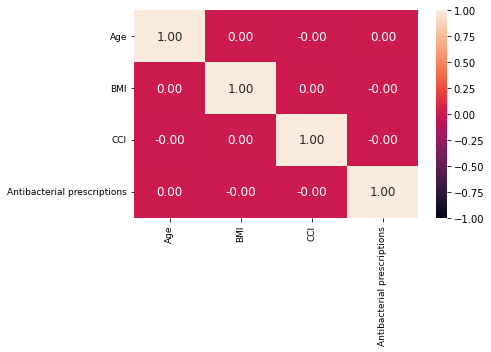

In [36]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(data_ot_externa[['age', 'bmi', 'CCI', 'antibacterial_brit']].corr(), 
            annot=True, fmt=".2f", annot_kws={"size":12},
            vmin=-1.0, vmax=1.0)

ax.set_xticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions'], rotation=90, fontsize=9)
ax.set_yticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions',], rotation=0, fontsize=9)                        
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_ot_externa/corr_ot_externa.jpg')
plt.show()

## 4- separate data of incident/prevalent and with/without antibiotics and stratified sub-datasets

In [37]:
data_ot_externa = data_ot_externa[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 
                                   'antibacterial_brit', 'antibacterial_brit_cat', 'ot_externa_ab_date', 'ab_type_cat', 'incdt_ot_externa_date', 'date', 'period',
                                   'event_ot_externa_admitted', 'duration_ot_externa_admitted'
                                    ]]

In [38]:
#incident and prevalent infection 
data_ot_externa_incdt = data_ot_externa[data_ot_externa['incdt_ot_externa_date'] == 0]
data_ot_externa_prevl = data_ot_externa[data_ot_externa['incdt_ot_externa_date'] == 1]
#switch variable ot_externa_ab_date into a binary variable
data_ot_externa_incdt[['ot_externa_ab_date']] = data_ot_externa_incdt[['ot_externa_ab_date']].where(data_ot_externa_incdt[['ot_externa_ab_date']].isnull(), 1).fillna(0).astype(int)
data_ot_externa_prevl[['ot_externa_ab_date']] = data_ot_externa_prevl[['ot_externa_ab_date']].where(data_ot_externa_prevl[['ot_externa_ab_date']].isnull(), 1).fillna(0).astype(int)

#incident and prevalent infection stratified by sex categories
data_ot_externa_incdt_males = data_ot_externa_incdt[data_ot_externa_incdt['sex'] == 'male']
data_ot_externa_incdt_females = data_ot_externa_incdt[data_ot_externa_incdt['sex'] == 'female']
data_ot_externa_prevl_males = data_ot_externa_prevl[data_ot_externa_prevl['sex'] == 'male']
data_ot_externa_prevl_females = data_ot_externa_prevl[data_ot_externa_prevl['sex'] == 'female']

#incident and prevalent infection stratified by age categories
data_ot_externa_incdt_15_24 = data_ot_externa_incdt[data_ot_externa_incdt['age_cat'] == '15_24']
data_ot_externa_incdt_25_34 = data_ot_externa_incdt[data_ot_externa_incdt['age_cat'] == '25_34']
data_ot_externa_incdt_35_44 = data_ot_externa_incdt[data_ot_externa_incdt['age_cat'] == '35_44']
data_ot_externa_incdt_45_54 = data_ot_externa_incdt[data_ot_externa_incdt['age_cat'] == '45_54']
data_ot_externa_incdt_55_64 = data_ot_externa_incdt[data_ot_externa_incdt['age_cat'] == '55_64']
data_ot_externa_incdt_65_74 = data_ot_externa_incdt[data_ot_externa_incdt['age_cat'] == '65_74']
data_ot_externa_incdt_75_more = data_ot_externa_incdt[data_ot_externa_incdt['age_cat'] == '75_more']
data_ot_externa_prevl_15_24 = data_ot_externa_prevl[data_ot_externa_prevl['age_cat'] == '15_24']
data_ot_externa_prevl_25_34 = data_ot_externa_prevl[data_ot_externa_prevl['age_cat'] == '25_34']
data_ot_externa_prevl_35_44 = data_ot_externa_prevl[data_ot_externa_prevl['age_cat'] == '35_44']
data_ot_externa_prevl_45_54 = data_ot_externa_prevl[data_ot_externa_prevl['age_cat'] == '45_54']
data_ot_externa_prevl_55_64 = data_ot_externa_prevl[data_ot_externa_prevl['age_cat'] == '55_64']
data_ot_externa_prevl_65_74 = data_ot_externa_prevl[data_ot_externa_prevl['age_cat'] == '65_74']
data_ot_externa_prevl_75_more = data_ot_externa_prevl[data_ot_externa_prevl['age_cat'] == '75_more']

#incident and prevalent infection stratified by time period categories
data_ot_externa_incdt_prepandemic = data_ot_externa_incdt[data_ot_externa_incdt['date'] <= '2019-12']
data_ot_externa_incdt_during_pandemic = data_ot_externa_incdt[(data_ot_externa_incdt['date'] >= '2020-03') & (data_ot_externa_incdt['date']<= '2021-03')]
data_ot_externa_incdt_post_2nd_lockdown = data_ot_externa_incdt[data_ot_externa_incdt['date'] <= '2021-04']
data_ot_externa_prevl_prepandemic = data_ot_externa_prevl[data_ot_externa_prevl['date'] <= '2019-12']
data_ot_externa_prevl_during_pandemic = data_ot_externa_prevl[(data_ot_externa_prevl['date'] >= '2020-03') & (data_ot_externa_prevl['date']<= '2021-03')]
data_ot_externa_prevl_post_2nd_lockdown = data_ot_externa_prevl[data_ot_externa_prevl['date'] <= '2021-04']

#incident and prevalent infection stratified by antibiotics history categories
data_ot_externa_incdt_none0 = data_ot_externa_incdt[data_ot_externa_incdt['antibacterial_brit_cat'] == 'none0']
data_ot_externa_incdt_low1 = data_ot_externa_incdt[data_ot_externa_incdt['antibacterial_brit_cat'] == 'low1']
data_ot_externa_incdt_medium2_4 = data_ot_externa_incdt[data_ot_externa_incdt['antibacterial_brit_cat'] == 'medium2_4']
data_ot_externa_incdt_high5_more = data_ot_externa_incdt[data_ot_externa_incdt['antibacterial_brit_cat'] == 'high5_more']
data_ot_externa_prevl_none0 = data_ot_externa_prevl[data_ot_externa_prevl['antibacterial_brit_cat'] == 'none0']
data_ot_externa_prevl_low1 = data_ot_externa_prevl[data_ot_externa_prevl['antibacterial_brit_cat'] == 'low1']
data_ot_externa_prevl_medium2_4 = data_ot_externa_prevl[data_ot_externa_prevl['antibacterial_brit_cat'] == 'medium2_4']
data_ot_externa_prevl_high5_more = data_ot_externa_prevl[data_ot_externa_prevl['antibacterial_brit_cat'] == 'high5_more']

# no antibiotics and incident hospital admission
data_ot_externa_no_abs_incdt = data_ot_externa[data_ot_externa['ot_externa_ab_date'].isnull()]
data_ot_externa_no_abs_incdt = data_ot_externa_no_abs_incdt[data_ot_externa_no_abs_incdt['incdt_ot_externa_date'] == 0]

# with antibiotics and incident hospital admission
data_ot_externa_abs_incdt = data_ot_externa[data_ot_externa['ot_externa_ab_date'].notnull()]
data_ot_externa_abs_incdt = data_ot_externa_abs_incdt[data_ot_externa_abs_incdt['incdt_ot_externa_date'] == 0]

# no antibiotics and prevalent hospital admission
data_ot_externa_no_abs_prevl = data_ot_externa[data_ot_externa['ot_externa_ab_date'].isnull()]
data_ot_externa_no_abs_prevl = data_ot_externa_no_abs_prevl[data_ot_externa_no_abs_prevl['incdt_ot_externa_date'] == 1]

# with antibiotics and prevalent hospital admission
data_ot_externa_abs_prevl = data_ot_externa[data_ot_externa['ot_externa_ab_date'].notnull()]
data_ot_externa_abs_prevl = data_ot_externa_abs_prevl[data_ot_externa_abs_prevl['incdt_ot_externa_date'] == 1]

In [39]:
#store data for plotting hosp admission counts and percentages
%store data_ot_externa
# save data
data_ot_externa.to_csv('../output/hospitalisation_prediction_ot_externa/data_ot_externa.csv')

Stored 'data_ot_externa' (DataFrame)


## 5- cox modelling for hospital admissions
### 5-1- incident ot_externa with no antibiotics

<lifelines.CoxPHFitter: fitted with 108393 total observations, 107734 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 108393
number of events observed = 659
   partial log-likelihood = -7616.02
         time fit was run = 2023-06-21 08:31:16 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.11       0.90       0.11            -0.33             0.11                 0.72                 1.12
CCI_cat[T.medium]               -0.08       0.92       0.12            -0.33             0.16                 0.72                 1.18
CCI_cat[T.high]                 -0.14       0.87       0.15            -0.44             0.16                 0.64                 1.17
CCI_cat[T.very_high]            -0.13       0.88       0.13            -0.39             0.13                 0.67                 1.14
age_cat[T.25_34]                 0.22       1.25       0.15            -0.07             0.52                 0.93                 1.67
age_cat[T.35_44]                 0.09       1.10       0.15            -0.21             0.39                 0.81                 1.48
age_cat[T.45_54]                 0.25       1.28       0.15            -0.04             0.54                 0.96                 1.71
age_cat[T.55_64]                 0.01       1.01       0.16            -0.29             0.32                 0.75                 1.38
age_cat[T.65_74]                 0.12       1.13       0.15            -0.18             0.42                 0.84                 1.52
age_cat[T.75_more]               0.30       1.35       0.15             0.01             0.59                 1.01                 1.80
antibacterial_brit               0.01       1.01       0.03            -0.05             0.06                 0.96                 1.06
bmi_cat[T.obese]                 0.11       1.12       0.16            -0.20             0.41                 0.82                 1.51
bmi_cat[T.overweight]           -0.01       0.99       0.19            -0.38             0.37                 0.68                 1.45
bmi_cat[T.underweight]           0.38       1.46       0.24            -0.10             0.85                 0.91                 2.34
bmi_cat[T.unknown]               0.25       1.28       0.16            -0.07             0.57                 0.93                 1.76
ethnicity[T.unknown]            -0.18       0.84       0.13            -0.43             0.07                 0.65                 1.07
ethnicity[T.white]              -0.06       0.94       0.11            -0.27             0.16                 0.76                 1.17
flu_vaccine[T.yes]              -0.08       0.93       0.13            -0.34             0.19                 0.71                 1.20
imd[T.medium]                   -0.16       0.85       0.13            -0.41             0.10                 0.66                 1.11
imd[T.unaffluent]                0.06       1.07       0.12            -0.18             0.31                 0.84                 1.36
imd[T.unknown]                  -0.34       0.71       0.22            -0.78             0.10                 0.46                 1.10
imd[T.very_affluent]             0.04       1.04       0.12            -0.20             0.28                 0.82                 1.33
imd[T.very_unaffluent]           0.07       1.07       0.12            -0.17             0.31                 0.84                 1.37
region[T.east_midlands]          0.44       1.56       0.17             0.11             0.78                 1.12                 2.18
region[T.london]                 0.09       1.10     

12765


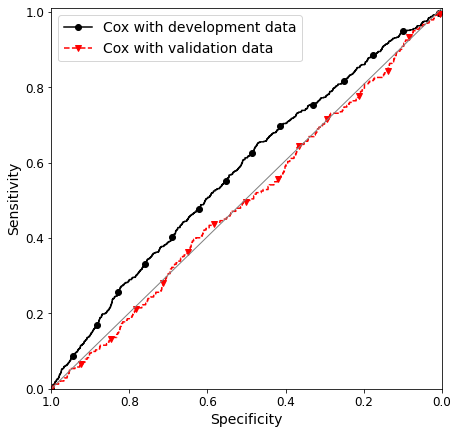

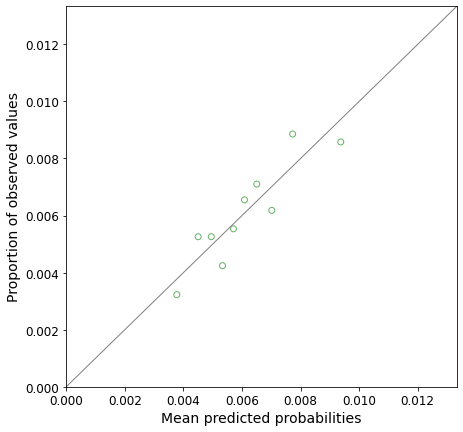

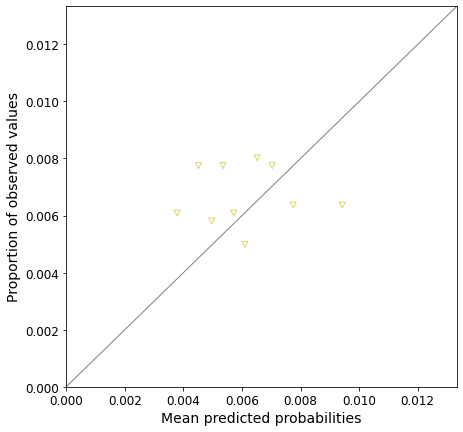

In [40]:
#data prep
data, data_ot_externa_no_abs_incdt_enc = cox_data_prep(data_ot_externa_no_abs_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_ot_externa_admitted', 'duration_ot_externa_admitted'])

#make summary table
make_summary_table('ot_externa', 'no_abs_incdt', data_ot_externa_no_abs_incdt_enc)

#make summary table of hosped
make_summary_table_hosped('ot_externa', 'no_abs_incdt', data_ot_externa_no_abs_incdt)

try:
    #build cox model 
    cph_ot_externa_no_abs_incdt, data_ot_externa_no_abs_incdt_train, data_ot_externa_no_abs_incdt_test = cox_model_build('ot_externa', 'no_abs_incdt', data_ot_externa_no_abs_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    cox_betas_sumbetas_calculate(cph_ot_externa_no_abs_incdt, '../output/hospitalisation_prediction_ot_externa/', 'betas_cph_ot_externa_no_abs_incdt.csv', data_ot_externa_no_abs_incdt_enc, data_ot_externa_no_abs_incdt, 'sum_betas_cph_ot_externa_no_abs_incdt.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cox_roc_curve(cph_ot_externa_no_abs_incdt, 'event_ot_externa_admitted', data_ot_externa_no_abs_incdt_train, data_ot_externa_no_abs_incdt_test, '../output/hospitalisation_prediction_ot_externa', 'roc_cph_ot_externa_no_abs_incdt.jpg')

    #plot calibration plots with development and validation data
    cox_calibration(cph_ot_externa_no_abs_incdt, data_ot_externa_no_abs_incdt_train, 'event_ot_externa_admitted', data_ot_externa_no_abs_incdt_test, '../output/hospitalisation_prediction_ot_externa/', 'calibration_cph_ot_externa_no_abs_incdt_train.jpg', 'calibration_cph_ot_externa_no_abs_incdt_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cox_output(cph_ot_externa_no_abs_incdt, 'ot_externa', 'no_abs_incdt', data_ot_externa_no_abs_incdt_train, data_ot_externa_no_abs_incdt_test, 'event_ot_externa_admitted', 'duration_ot_externa_admitted', '../output/hospitalisation_prediction_ot_externa/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-2- incident ot_externa with antibiotics

<lifelines.CoxPHFitter: fitted with 12077 total observations, 12004 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 12077
number of events observed = 73
   partial log-likelihood = -663.87
         time fit was run = 2023-06-21 08:31:28 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.11       0.90       0.36            -0.81             0.59                 0.44                 1.80
CCI_cat[T.medium]                0.30       1.35       0.37            -0.41             1.02                 0.66                 2.78
CCI_cat[T.high]                 -0.31       0.73       0.50            -1.29             0.67                 0.28                 1.96
CCI_cat[T.very_high]            -0.09       0.92       0.41            -0.89             0.72                 0.41                 2.05
age_cat[T.25_34]                 0.10       1.11       0.45            -0.78             0.98                 0.46                 2.66
age_cat[T.35_44]                -0.42       0.66       0.52            -1.44             0.59                 0.24                 1.81
age_cat[T.45_54]                 0.06       1.06       0.45            -0.82             0.94                 0.44                 2.55
age_cat[T.55_64]                 0.55       1.73       0.40            -0.24             1.34                 0.78                 3.83
age_cat[T.65_74]                 0.35       1.42       0.42            -0.48             1.18                 0.62                 3.25
age_cat[T.75_more]              -0.13       0.88       0.48            -1.06             0.81                 0.35                 2.24
antibacterial_brit              -0.21       0.81       0.09            -0.39            -0.03                 0.68                 0.97
bmi_cat[T.obese]                -0.27       0.77       0.42            -1.08             0.55                 0.34                 1.73
bmi_cat[T.overweight]            0.07       1.07       0.49            -0.90             1.04                 0.41                 2.83
bmi_cat[T.underweight]           0.28       1.32       0.69            -1.08             1.63                 0.34                 5.13
bmi_cat[T.unknown]              -0.18       0.83       0.44            -1.05             0.69                 0.35                 1.99
ethnicity[T.unknown]            -0.21       0.81       0.38            -0.96             0.54                 0.38                 1.71
ethnicity[T.white]              -0.08       0.93       0.33            -0.71             0.56                 0.49                 1.76
flu_vaccine[T.yes]              -0.95       0.39       0.59            -2.11             0.20                 0.12                 1.22
imd[T.medium]                   -0.64       0.53       0.43            -1.49             0.21                 0.23                 1.24
imd[T.unaffluent]                0.21       1.24       0.34            -0.45             0.88                 0.64                 2.41
imd[T.unknown]                  -1.44       0.24       1.03            -3.46             0.59                 0.03                 1.80
imd[T.very_affluent]            -0.23       0.80       0.37            -0.96             0.51                 0.38                 1.66
imd[T.very_unaffluent]           0.00       1.00       0.35            -0.69             0.70                 0.50                 2.01
region[T.east_midlands]         -0.64       0.53       0.43            -1.49             0.21                 0.23                 1.24
region[T.london]                -0.95       0.39       0.3

12793


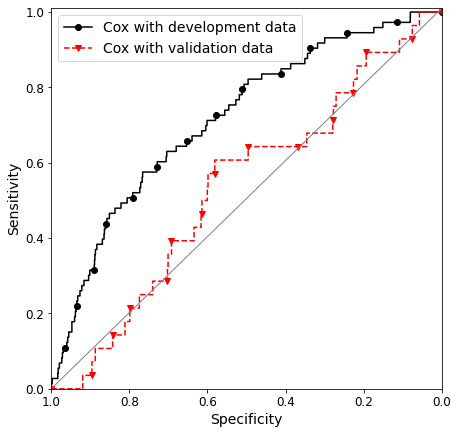

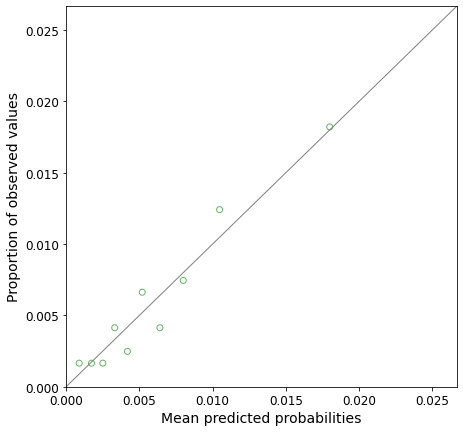

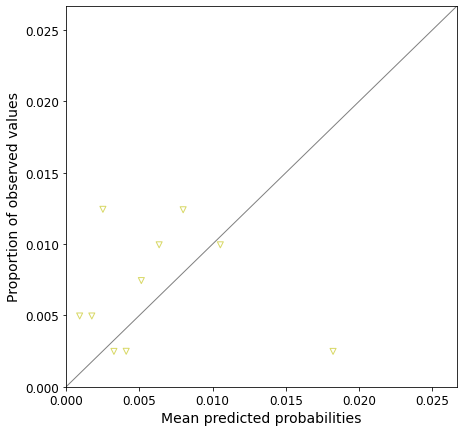

In [41]:
#data prep
data, data_ot_externa_abs_incdt_enc = cox_data_prep(data_ot_externa_abs_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_ot_externa_admitted', 'duration_ot_externa_admitted'])

#make summary table
make_summary_table('ot_externa', 'abs_incdt', data_ot_externa_abs_incdt_enc)

#make summary table of hosped
make_summary_table_hosped('ot_externa', 'abs_incdt', data_ot_externa_abs_incdt)

try:
    #build cox model 
    cph_ot_externa_abs_incdt, data_ot_externa_abs_incdt_train, data_ot_externa_abs_incdt_test = cox_model_build('ot_externa', 'abs_incdt', data_ot_externa_abs_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    cox_betas_sumbetas_calculate(cph_ot_externa_abs_incdt, '../output/hospitalisation_prediction_ot_externa/', 'betas_cph_ot_externa_abs_incdt.csv', data_ot_externa_abs_incdt_enc, data_ot_externa_abs_incdt, 'sum_betas_cph_ot_externa_abs_incdt.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cox_roc_curve(cph_ot_externa_abs_incdt, 'event_ot_externa_admitted', data_ot_externa_abs_incdt_train, data_ot_externa_abs_incdt_test, '../output/hospitalisation_prediction_ot_externa', 'roc_cph_ot_externa_abs_incdt.jpg')

    #plot calibration plots with development and validation data
    cox_calibration(cph_ot_externa_abs_incdt, data_ot_externa_abs_incdt_train, 'event_ot_externa_admitted', data_ot_externa_abs_incdt_test, '../output/hospitalisation_prediction_ot_externa/', 'calibration_cph_ot_externa_abs_incdt_train.jpg', 'calibration_cph_ot_externa_abs_incdt_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cox_output(cph_ot_externa_abs_incdt, 'ot_externa', 'abs_incdt', data_ot_externa_abs_incdt_train, data_ot_externa_abs_incdt_test, 'event_ot_externa_admitted', 'duration_ot_externa_admitted', '../output/hospitalisation_prediction_ot_externa/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-3- prevalent ot_externa with no antibiotics

<lifelines.CoxPHFitter: fitted with 11858 total observations, 11772 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 11858
number of events observed = 86
   partial log-likelihood = -786.96
         time fit was run = 2023-06-21 08:31:31 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.39       0.67       0.30            -0.98             0.19                 0.38                 1.21
CCI_cat[T.medium]               -0.16       0.85       0.32            -0.79             0.47                 0.45                 1.60
CCI_cat[T.high]                 -0.38       0.68       0.42            -1.21             0.45                 0.30                 1.57
CCI_cat[T.very_high]            -0.53       0.59       0.38            -1.27             0.22                 0.28                 1.24
age_cat[T.25_34]                 0.43       1.54       0.53            -0.61             1.46                 0.55                 4.32
age_cat[T.35_44]                 0.56       1.75       0.51            -0.43             1.56                 0.65                 4.75
age_cat[T.45_54]                 1.16       3.19       0.47             0.25             2.07                 1.28                 7.95
age_cat[T.55_64]                 0.66       1.93       0.50            -0.32             1.64                 0.72                 5.16
age_cat[T.65_74]                 1.09       2.98       0.48             0.16             2.02                 1.17                 7.56
age_cat[T.75_more]               0.55       1.73       0.51            -0.45             1.55                 0.64                 4.69
antibacterial_brit              -0.01       0.99       0.08            -0.16             0.14                 0.85                 1.15
bmi_cat[T.obese]                -0.82       0.44       0.32            -1.45            -0.19                 0.23                 0.83
bmi_cat[T.overweight]           -0.71       0.49       0.44            -1.56             0.14                 0.21                 1.15
bmi_cat[T.underweight]          -0.68       0.51       0.64            -1.94             0.58                 0.14                 1.79
bmi_cat[T.unknown]              -0.61       0.54       0.35            -1.30             0.07                 0.27                 1.07
ethnicity[T.unknown]             0.32       1.38       0.36            -0.39             1.03                 0.68                 2.81
ethnicity[T.white]               0.14       1.15       0.33            -0.51             0.80                 0.60                 2.22
flu_vaccine[T.yes]               0.48       1.61       0.30            -0.12             1.07                 0.89                 2.91
imd[T.medium]                   -0.23       0.79       0.37            -0.96             0.50                 0.38                 1.65
imd[T.unaffluent]                0.24       1.27       0.34            -0.42             0.91                 0.65                 2.48
imd[T.unknown]                  -0.03       0.97       0.56            -1.12             1.07                 0.32                 2.92
imd[T.very_affluent]            -0.05       0.95       0.36            -0.75             0.66                 0.47                 1.93
imd[T.very_unaffluent]           0.24       1.27       0.34            -0.43             0.90                 0.65                 2.47
region[T.east_midlands]          0.20       1.23       0.41            -0.60             1.01                 0.55                 2.74
region[T.london]                -0.08       0.93       0.3

12785


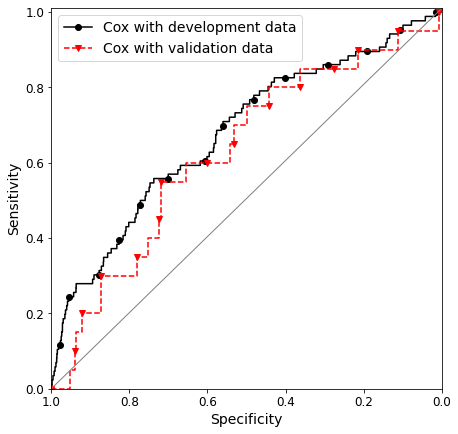

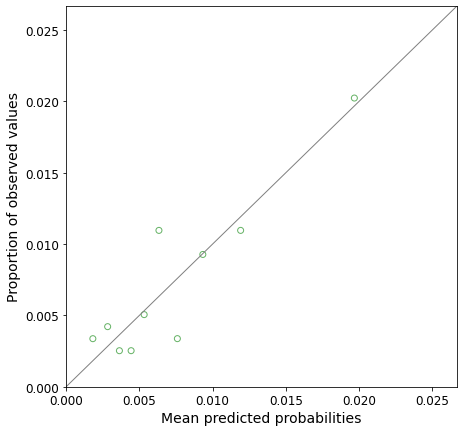

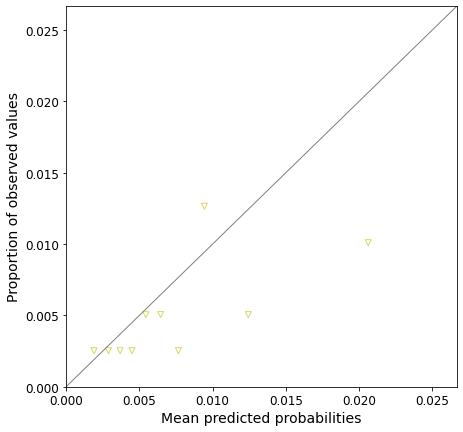

In [42]:
#data prep
data, data_ot_externa_no_abs_prevl_enc = cox_data_prep(data_ot_externa_no_abs_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_ot_externa_admitted', 'duration_ot_externa_admitted'])

#make summary table
make_summary_table('ot_externa', 'no_abs_prevl', data_ot_externa_no_abs_prevl_enc)

#make summary table of hosped
make_summary_table_hosped('ot_externa', 'no_abs_prevl', data_ot_externa_no_abs_prevl)

try:
    #build cox model 
    cph_ot_externa_no_abs_prevl, data_ot_externa_no_abs_prevl_train, data_ot_externa_no_abs_prevl_test = cox_model_build('ot_externa', 'no_abs_prevl', data_ot_externa_no_abs_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:    
    #calculate and save betas and sum of betas 
    cox_betas_sumbetas_calculate(cph_ot_externa_no_abs_prevl, '../output/hospitalisation_prediction_ot_externa/', 'betas_cph_ot_externa_no_abs_prevl.csv', data_ot_externa_no_abs_prevl_enc, data_ot_externa_no_abs_prevl, 'sum_betas_cph_ot_externa_no_abs_prevl.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cox_roc_curve(cph_ot_externa_no_abs_prevl, 'event_ot_externa_admitted', data_ot_externa_no_abs_prevl_train, data_ot_externa_no_abs_prevl_test, '../output/hospitalisation_prediction_ot_externa', 'roc_cph_ot_externa_no_abs_prevl.jpg')

    #plot calibration plots with development and validation data
    cox_calibration(cph_ot_externa_no_abs_prevl, data_ot_externa_no_abs_prevl_train, 'event_ot_externa_admitted', data_ot_externa_no_abs_prevl_test, '../output/hospitalisation_prediction_ot_externa/', 'calibration_cph_ot_externa_no_abs_prevl_train.jpg', 'calibration_cph_ot_externa_no_abs_prevl_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cox_output(cph_ot_externa_no_abs_prevl, 'ot_externa', 'no_abs_prevl', data_ot_externa_no_abs_prevl_train, data_ot_externa_no_abs_prevl_test, 'event_ot_externa_admitted', 'duration_ot_externa_admitted', '../output/hospitalisation_prediction_ot_externa/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-4- prevalent ot_externa with antibiotics

<lifelines.CoxPHFitter: fitted with 1296 total observations, 1289 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 1296
number of events observed = 7
   partial log-likelihood = -33.18
         time fit was run = 2023-06-21 08:31:37 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -1.01       0.37       1.28            -3.51             1.50                 0.03                 4.47
CCI_cat[T.medium]               -0.63       0.53       1.45            -3.47             2.21                 0.03                 9.12
CCI_cat[T.high]                 -0.25       0.78       1.47            -3.13             2.63                 0.04                13.89
CCI_cat[T.very_high]            -0.35       0.70       1.41            -3.12             2.42                 0.04                11.22
age_cat[T.25_34]                -0.63       0.53       1.68            -3.92             2.66                 0.02                14.26
age_cat[T.35_44]               -18.28       0.00    8838.41        -17341.25         17304.69                 0.00                  inf
age_cat[T.45_54]                -0.19       0.82       1.75            -3.62             3.23                 0.03                25.35
age_cat[T.55_64]                 0.28       1.33       1.48            -2.61             3.18                 0.07                23.98
age_cat[T.65_74]                 0.85       2.33       1.46            -2.02             3.71                 0.13                41.05
age_cat[T.75_more]             -18.28       0.00    8685.10        -17040.77         17004.21                 0.00                  inf
antibacterial_brit              -0.35       0.70       0.39            -1.12             0.42                 0.33                 1.52
bmi_cat[T.obese]                17.98   6.41e+07   17807.19        -34883.47         34919.43                 0.00                  inf
bmi_cat[T.overweight]           20.73   1.01e+09   17807.19        -34880.72         34922.18                 0.00                  inf
bmi_cat[T.underweight]          20.60   8.82e+08   17807.19        -34880.85         34922.05                 0.00                  inf
bmi_cat[T.unknown]              19.91   4.44e+08   17807.19        -34881.54         34921.36                 0.00                  inf
ethnicity[T.unknown]            17.16   2.83e+07    5928.27        -11602.04         11636.36                 0.00                  inf
ethnicity[T.white]              16.97   2.34e+07    5928.27        -11602.24         11636.17                 0.00                  inf
flu_vaccine[T.yes]             -18.59       0.00    9709.88        -19049.62         19012.43                 0.00                  inf
imd[T.medium]                   -0.56       0.57       1.39            -3.29             2.18                 0.04                 8.82
imd[T.unaffluent]               -0.45       0.64       1.39            -3.17             2.28                 0.04                 9.74
imd[T.unknown]                 -18.15       0.00   12378.15        -24278.87         24242.58                 0.00                  inf
imd[T.very_affluent]            -0.65       0.52       1.40            -3.39             2.09                 0.03                 8.10
imd[T.very_unaffluent]          -0.03       0.97       1.22            -2.42             2.37                 0.09                10.66
region[T.east_midlands]        -18.50       0.00   11037.25        -21651.11         21614.10                 0.00                  inf
region[T.london]                 0.03       1.03       1.42    

13029


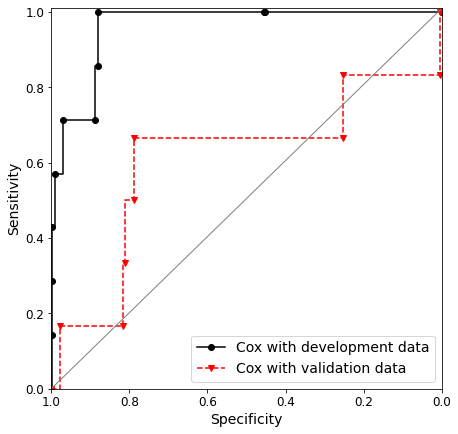

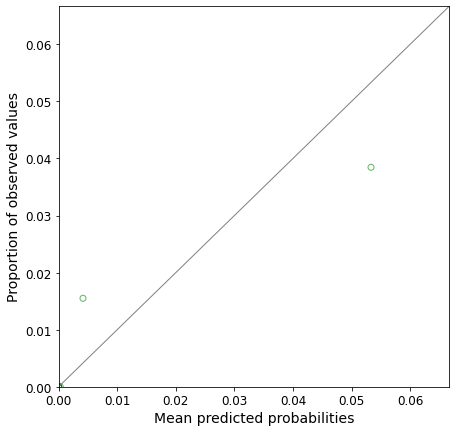

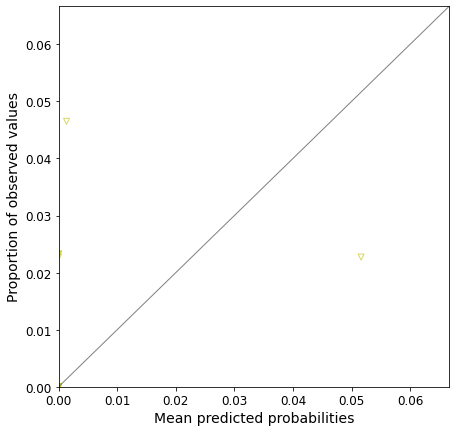

In [43]:
#data prep
data, data_ot_externa_abs_prevl_enc = cox_data_prep(data_ot_externa_abs_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_ot_externa_admitted', 'duration_ot_externa_admitted'])

#make summary table
make_summary_table('ot_externa', 'abs_prevl', data_ot_externa_abs_prevl_enc)

#make summary table of hosped
make_summary_table_hosped('ot_externa', 'abs_prevl', data_ot_externa_abs_prevl)

try:
    #build cox model 
    cph_ot_externa_abs_prevl, data_ot_externa_abs_prevl_train, data_ot_externa_abs_prevl_test = cox_model_build('ot_externa', 'abs_prevl', data_ot_externa_abs_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    cox_betas_sumbetas_calculate(cph_ot_externa_abs_prevl, '../output/hospitalisation_prediction_ot_externa/', 'betas_cph_ot_externa_abs_prevl.csv', data_ot_externa_abs_prevl_enc, data_ot_externa_abs_prevl, 'sum_betas_cph_ot_externa_abs_prevl.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cox_roc_curve(cph_ot_externa_abs_prevl, 'event_ot_externa_admitted', data_ot_externa_abs_prevl_train, data_ot_externa_abs_prevl_test, '../output/hospitalisation_prediction_ot_externa', 'roc_cph_ot_externa_abs_prevl.jpg')

    #plot calibration plots with development and validation data
    cox_calibration(cph_ot_externa_abs_prevl, data_ot_externa_abs_prevl_train, 'event_ot_externa_admitted', data_ot_externa_abs_prevl_test, '../output/hospitalisation_prediction_ot_externa/', 'calibration_cph_ot_externa_abs_prevl_train.jpg', 'calibration_cph_ot_externa_abs_prevl_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cox_output(cph_ot_externa_abs_prevl, 'ot_externa', 'abs_prevl', data_ot_externa_abs_prevl_train, data_ot_externa_abs_prevl_test, 'event_ot_externa_admitted', 'duration_ot_externa_admitted', '../output/hospitalisation_prediction_ot_externa/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-5- incident ot_externa

In [44]:
#data prep
data, data_ot_externa_incdt_enc = cox_data_prep(data_ot_externa_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ot_externa_ab_date'], ['antibacterial_brit'], ['event_ot_externa_admitted', 'duration_ot_externa_admitted'])

#make summary tables from preped data
make_summary_table('ot_externa', 'incdt', data_ot_externa_incdt_enc)
make_summary_table_hosped('ot_externa', 'incdt', data_ot_externa_incdt)

try:
    cph_ot_externa_incdt, data_ot_externa_incdt_train, data_ot_externa_incdt_test = cox_model_abs_build('ot_externa', 'incdt', data_ot_externa_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_ot_externa_incdt, 'ot_externa', 'incdt', data_ot_externa_incdt_train, data_ot_externa_incdt_test, 'event_ot_externa_admitted', 'duration_ot_externa_admitted', '../output/hospitalisation_prediction_ot_externa/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 120470 total observations, 119732 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 120470
number of events observed = 738
   partial log-likelihood = -8612.39
         time fit was run = 2023-06-21 08:31:48 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.05       0.95       0.11            -0.26             0.16                 0.77                 1.17
CCI_cat[T.medium]               -0.06       0.94       0.12            -0.29             0.17                 0.74                 1.18
CCI_cat[T.high]                 -0.12       0.89       0.14            -0.40             0.17                 0.67                 1.18
CCI_cat[T.very_high]            -0.17       0.84       0.13            -0.42             0.08                 0.66                 1.08
age_cat[T.25_34]                 0.12       1.13       0.14            -0.15             0.39                 0.86                 1.47
age_cat[T.35_44]                -0.13       0.88       0.14            -0.41             0.16                 0.66                 1.17
age_cat[T.45_54]                 0.13       1.14       0.14            -0.14             0.40                 0.87                 1.49
age_cat[T.55_64]                -0.01       0.99       0.14            -0.29             0.26                 0.75                 1.30
age_cat[T.65_74]                 0.06       1.06       0.14            -0.21             0.33                 0.81                 1.39
age_cat[T.75_more]               0.09       1.10       0.14            -0.18             0.36                 0.84                 1.44
antibacterial_brit               0.03       1.03       0.03            -0.02             0.08                 0.98                 1.09
bmi_cat[T.obese]                 0.07       1.07       0.14            -0.22             0.35                 0.81                 1.42
bmi_cat[T.overweight]           -0.02       0.98       0.18            -0.37             0.33                 0.69                 1.39
bmi_cat[T.underweight]           0.32       1.37       0.23            -0.13             0.76                 0.88                 2.15
bmi_cat[T.unknown]               0.18       1.20       0.15            -0.11             0.48                 0.89                 1.62
ethnicity[T.unknown]            -0.16       0.85       0.12            -0.39             0.07                 0.68                 1.08
ethnicity[T.white]              -0.08       0.92       0.10            -0.28             0.12                 0.75                 1.13
flu_vaccine[T.yes]              -0.16       0.85       0.13            -0.42             0.09                 0.66                 1.10
imd[T.medium]                   -0.08       0.92       0.12            -0.32             0.16                 0.72                 1.18
imd[T.unaffluent]                0.09       1.10       0.12            -0.14             0.32                 0.87                 1.38
imd[T.unknown]                   0.00       1.00       0.19            -0.37             0.37                 0.69                 1.44
imd[T.very_affluent]             0.07       1.07       0.12            -0.17             0.30                 0.85                 1.35
imd[T.very_unaffluent]           0.09       1.09       0.12            -0.14             0.32                 0.87                 1.38
ot_externa_ab_date               0.06       1.07       0.12            -0.17             0.30                 0.84                 1.35
region[T.east_midlands]          0.35       1.42     

13051


### 5-6- hospital admission related to prevalent ot_externa

In [45]:
#data prep
data, data_ot_externa_prevl_enc = cox_data_prep(data_ot_externa_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ot_externa_ab_date'], ['antibacterial_brit'], ['event_ot_externa_admitted', 'duration_ot_externa_admitted'])

#make summary tables from preped data
make_summary_table('ot_externa', 'prevl', data_ot_externa_prevl_enc)
make_summary_table_hosped('ot_externa', 'prevl', data_ot_externa_prevl)

try:
    cph_ot_externa_prevl, data_ot_externa_prevl_train, data_ot_externa_prevl_test = cox_model_abs_build('ot_externa', 'prevl', data_ot_externa_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_ot_externa_prevl, 'ot_externa', 'prevl', data_ot_externa_prevl_train, data_ot_externa_prevl_test, 'event_ot_externa_admitted', 'duration_ot_externa_admitted', '../output/hospitalisation_prediction_ot_externa/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 13155 total observations, 13063 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 13155
number of events observed = 92
   partial log-likelihood = -850.85
         time fit was run = 2023-06-21 08:32:00 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.43       0.65       0.29            -1.01             0.14                 0.37                 1.15
CCI_cat[T.medium]               -0.11       0.89       0.31            -0.72             0.50                 0.49                 1.64
CCI_cat[T.high]                 -0.31       0.73       0.40            -1.10             0.48                 0.33                 1.61
CCI_cat[T.very_high]            -0.43       0.65       0.36            -1.13             0.27                 0.32                 1.31
age_cat[T.25_34]                 0.46       1.59       0.48            -0.49             1.41                 0.61                 4.10
age_cat[T.35_44]                 0.40       1.50       0.48            -0.55             1.35                 0.58                 3.87
age_cat[T.45_54]                 0.92       2.51       0.45             0.04             1.79                 1.05                 6.01
age_cat[T.55_64]                 0.82       2.26       0.45            -0.06             1.70                 0.94                 5.47
age_cat[T.65_74]                 1.04       2.82       0.44             0.17             1.91                 1.19                 6.72
age_cat[T.75_more]               0.20       1.22       0.50            -0.79             1.19                 0.45                 3.28
antibacterial_brit              -0.09       0.91       0.08            -0.24             0.06                 0.79                 1.06
bmi_cat[T.obese]                -0.09       0.91       0.41            -0.89             0.71                 0.41                 2.04
bmi_cat[T.overweight]            0.42       1.51       0.46            -0.48             1.31                 0.62                 3.72
bmi_cat[T.underweight]           0.55       1.74       0.59            -0.60             1.71                 0.55                 5.50
bmi_cat[T.unknown]               0.10       1.10       0.43            -0.75             0.94                 0.47                 2.57
ethnicity[T.unknown]             0.68       1.98       0.38            -0.06             1.43                 0.94                 4.18
ethnicity[T.white]               0.38       1.46       0.36            -0.33             1.09                 0.72                 2.96
flu_vaccine[T.yes]               0.35       1.42       0.30            -0.24             0.94                 0.79                 2.55
imd[T.medium]                   -0.25       0.78       0.36            -0.95             0.45                 0.39                 1.57
imd[T.unaffluent]                0.28       1.32       0.32            -0.34             0.90                 0.71                 2.46
imd[T.unknown]                  -0.13       0.87       0.55            -1.22             0.95                 0.30                 2.59
imd[T.very_affluent]            -0.24       0.79       0.36            -0.94             0.46                 0.39                 1.58
imd[T.very_unaffluent]           0.08       1.08       0.33            -0.57             0.73                 0.57                 2.07
ot_externa_ab_date               0.21       1.24       0.32            -0.42             0.85                 0.66                 2.33
region[T.east_midlands]          0.11       1.11       0.4

13052


### 5-7- hospital admission related to incident ot_externa with prescribed antibiotics categories

In [46]:
#data prep
data, data_ot_externa_incdt_abs_enc = cox_data_prep(data_ot_externa_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ab_type_cat'], ['antibacterial_brit'], ['event_ot_externa_admitted', 'duration_ot_externa_admitted'])

try:
    #cox model
    cph_ot_externa_incdt_abs, data_ot_externa_incdt_abs_train, data_ot_externa_incdt_abs_test = cox_model_ab_type_build('ot_externa', 'incdt_ab_type', data_ot_externa_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_ot_externa_incdt_abs, 'ot_externa', 'incdt_abs', data_ot_externa_incdt_abs_train, data_ot_externa_incdt_abs_test, 'event_ot_externa_admitted', 'duration_ot_externa_admitted', '../output/hospitalisation_prediction_ot_externa/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 120470 total observations, 119732 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 120470
number of events observed = 738
   partial log-likelihood = -8609.63
         time fit was run = 2023-06-21 08:32:07 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.05       0.95       0.11            -0.26             0.16                 0.77                 1.17
CCI_cat[T.medium]               -0.06       0.94       0.12            -0.29             0.17                 0.74                 1.18
CCI_cat[T.high]                 -0.12       0.89       0.14            -0.40             0.16                 0.67                 1.18
CCI_cat[T.very_high]            -0.17       0.84       0.13            -0.42             0.08                 0.66                 1.08
ab_type_cat[T.Doxycycline]     -11.84       0.00     497.65          -987.23           963.54                 0.00                  inf
ab_type_cat[T.no]                0.86       2.37       0.71            -0.52             2.25                 0.59                 9.50
ab_type_cat[T.other]             0.99       2.68       0.72            -0.42             2.39                 0.66                10.93
age_cat[T.25_34]                 0.12       1.13       0.14            -0.15             0.39                 0.86                 1.47
age_cat[T.35_44]                -0.13       0.88       0.14            -0.41             0.16                 0.66                 1.17
age_cat[T.45_54]                 0.13       1.14       0.14            -0.14             0.40                 0.87                 1.49
age_cat[T.55_64]                -0.01       0.99       0.14            -0.29             0.26                 0.75                 1.30
age_cat[T.65_74]                 0.06       1.06       0.14            -0.21             0.33                 0.81                 1.39
age_cat[T.75_more]               0.09       1.10       0.14            -0.18             0.36                 0.84                 1.44
antibacterial_brit               0.03       1.03       0.03            -0.02             0.08                 0.98                 1.09
bmi_cat[T.obese]                 0.07       1.07       0.14            -0.22             0.35                 0.81                 1.42
bmi_cat[T.overweight]           -0.02       0.98       0.18            -0.37             0.33                 0.69                 1.39
bmi_cat[T.underweight]           0.32       1.38       0.23            -0.13             0.76                 0.88                 2.15
bmi_cat[T.unknown]               0.18       1.20       0.15            -0.11             0.48                 0.89                 1.62
ethnicity[T.unknown]            -0.16       0.85       0.12            -0.39             0.07                 0.68                 1.08
ethnicity[T.white]              -0.08       0.92       0.10            -0.28             0.12                 0.75                 1.13
flu_vaccine[T.yes]              -0.16       0.85       0.13            -0.42             0.09                 0.66                 1.10
imd[T.medium]                   -0.08       0.92       0.12            -0.32             0.16                 0.72                 1.18
imd[T.unaffluent]                0.09       1.10       0.12            -0.14             0.32                 0.87                 1.38
imd[T.unknown]                   0.00       1.00       0.19            -0.37             0.37                 0.69                 1.44
imd[T.very_affluent]             0.07       1.07     

13617


### 5-8- hospital admission related to prevalent ot_externa with prescribed antibiotics categories

In [47]:
#data prep
data, data_ot_externa_prevl_abs_enc = cox_data_prep(data_ot_externa_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ab_type_cat'], ['antibacterial_brit'], ['event_ot_externa_admitted', 'duration_ot_externa_admitted'])

try:
    #cox model
    cph_ot_externa_prevl_abs, data_ot_externa_prevl_abs_train, data_ot_externa_prevl_abs_test = cox_model_ab_type_build('ot_externa', 'prevl_ab_type', data_ot_externa_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_ot_externa_prevl_abs, 'ot_externa', 'prevl_abs', data_ot_externa_prevl_abs_train, data_ot_externa_prevl_abs_test, 'event_ot_externa_admitted', 'duration_ot_externa_admitted', '../output/hospitalisation_prediction_ot_externa/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 13155 total observations, 13063 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 13155
number of events observed = 92
   partial log-likelihood = -849.86
         time fit was run = 2023-06-21 08:32:16 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.43       0.65       0.29            -1.00             0.15                 0.37                 1.16
CCI_cat[T.medium]               -0.11       0.90       0.31            -0.71             0.50                 0.49                 1.65
CCI_cat[T.high]                 -0.30       0.74       0.40            -1.09             0.49                 0.34                 1.62
CCI_cat[T.very_high]            -0.43       0.65       0.36            -1.13             0.27                 0.32                 1.31
ab_type_cat[T.Doxycycline]      -0.14       0.87    4351.26         -8528.45          8528.18                 0.00                  inf
ab_type_cat[T.no]               14.76   2.58e+06    2138.12         -4175.87          4205.39                 0.00                  inf
ab_type_cat[T.other]            15.07   3.50e+06    2138.12         -4175.56          4205.70                 0.00                  inf
age_cat[T.25_34]                 0.46       1.59       0.48            -0.49             1.41                 0.61                 4.10
age_cat[T.35_44]                 0.40       1.50       0.48            -0.55             1.35                 0.58                 3.86
age_cat[T.45_54]                 0.91       2.49       0.45             0.04             1.79                 1.04                 5.97
age_cat[T.55_64]                 0.82       2.28       0.45            -0.06             1.71                 0.94                 5.51
age_cat[T.65_74]                 1.03       2.80       0.44             0.16             1.90                 1.18                 6.67
age_cat[T.75_more]               0.20       1.22       0.50            -0.79             1.19                 0.45                 3.28
antibacterial_brit              -0.09       0.91       0.08            -0.24             0.06                 0.79                 1.06
bmi_cat[T.obese]                -0.10       0.90       0.41            -0.91             0.70                 0.40                 2.02
bmi_cat[T.overweight]            0.41       1.50       0.46            -0.49             1.31                 0.61                 3.70
bmi_cat[T.underweight]           0.54       1.71       0.59            -0.62             1.69                 0.54                 5.41
bmi_cat[T.unknown]               0.09       1.09       0.43            -0.75             0.93                 0.47                 2.55
ethnicity[T.unknown]             0.68       1.98       0.38            -0.06             1.43                 0.94                 4.18
ethnicity[T.white]               0.38       1.46       0.36            -0.33             1.08                 0.72                 2.96
flu_vaccine[T.yes]               0.35       1.41       0.30            -0.24             0.94                 0.78                 2.55
imd[T.medium]                   -0.25       0.78       0.36            -0.95             0.45                 0.39                 1.57
imd[T.unaffluent]                0.28       1.33       0.32            -0.33             0.90                 0.72                 2.46
imd[T.unknown]                  -0.14       0.87       0.55            -1.22             0.95                 0.29                 2.58
imd[T.very_affluent]            -0.24       0.79       0.3

13645


### 5-9- stratified by sex
#### 5-9-1- incident males

In [48]:
#data prep
data, data_ot_externa_incdt_males_enc = cox_data_prep(data_ot_externa_incdt_males, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ot_externa_ab_date'], ['antibacterial_brit'], ['event_ot_externa_admitted', 'duration_ot_externa_admitted'])

try:
    #cox model
    cph_ot_externa_incdt_males, data_ot_externa_incdt_males_train, data_ot_externa_incdt_males_test = cox_model_strat_sex_build('ot_externa', 'incdt_males', data_ot_externa_incdt_males)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_ot_externa_incdt_males, 'ot_externa', 'incdt_males', data_ot_externa_incdt_males_train, data_ot_externa_incdt_males_test, 'event_ot_externa_admitted', 'duration_ot_externa_admitted', '../output/hospitalisation_prediction_ot_externa/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 58918 total observations, 58524 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 58918
number of events observed = 394
   partial log-likelihood = -4306.75
         time fit was run = 2023-06-21 08:32:19 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.01       0.99       0.15            -0.29             0.28                 0.75                 1.33
CCI_cat[T.medium]               -0.06       0.94       0.16            -0.39             0.26                 0.68                 1.29
CCI_cat[T.high]                  0.01       1.01       0.19            -0.37             0.39                 0.69                 1.47
CCI_cat[T.very_high]            -0.20       0.82       0.18            -0.55             0.15                 0.58                 1.16
age_cat[T.25_34]                -0.22       0.81       0.19            -0.59             0.16                 0.55                 1.17
age_cat[T.35_44]                -0.16       0.85       0.19            -0.53             0.21                 0.59                 1.24
age_cat[T.45_54]                -0.03       0.97       0.18            -0.38             0.33                 0.68                 1.39
age_cat[T.55_64]                -0.13       0.88       0.19            -0.49             0.24                 0.61                 1.27
age_cat[T.65_74]                 0.14       1.15       0.18            -0.20             0.49                 0.82                 1.63
age_cat[T.75_more]              -0.17       0.84       0.19            -0.54             0.20                 0.58                 1.23
antibacterial_brit               0.03       1.03       0.04            -0.04             0.10                 0.96                 1.10
bmi_cat[T.obese]                -0.04       0.97       0.19            -0.42             0.34                 0.66                 1.41
bmi_cat[T.overweight]            0.06       1.07       0.23            -0.39             0.52                 0.68                 1.68
bmi_cat[T.underweight]           0.10       1.10       0.32            -0.53             0.73                 0.59                 2.07
bmi_cat[T.unknown]               0.16       1.18       0.20            -0.24             0.56                 0.79                 1.75
ethnicity[T.unknown]            -0.31       0.73       0.16            -0.63             0.01                 0.53                 1.01
ethnicity[T.white]              -0.09       0.92       0.14            -0.36             0.19                 0.70                 1.20
flu_vaccine[T.yes]               0.22       1.25       0.16            -0.09             0.52                 0.92                 1.69
imd[T.medium]                   -0.05       0.95       0.17            -0.39             0.28                 0.67                 1.33
imd[T.unaffluent]                0.25       1.28       0.16            -0.07             0.56                 0.93                 1.75
imd[T.unknown]                  -0.27       0.76       0.29            -0.84             0.31                 0.43                 1.36
imd[T.very_affluent]             0.18       1.19       0.16            -0.14             0.50                 0.87                 1.64
imd[T.very_unaffluent]           0.12       1.12       0.17            -0.21             0.44                 0.81                 1.56
ot_externa_ab_date              -0.04       0.96       0.17            -0.38             0.29                 0.69                 1.34
region[T.east_midlands]          0.33       1.39       0

12786


#### 5-9-2- incident females

In [49]:
#data prep
data, data_ot_externa_incdt_females_enc = cox_data_prep(data_ot_externa_incdt_females, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ot_externa_ab_date'], ['antibacterial_brit'], ['event_ot_externa_admitted', 'duration_ot_externa_admitted'])

try:
    #cox model
    cph_ot_externa_incdt_females, data_ot_externa_incdt_females_train, data_ot_externa_incdt_females_test = cox_model_strat_sex_build('ot_externa', 'incdt_females', data_ot_externa_incdt_females)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_ot_externa_incdt_females, 'ot_externa', 'incdt_females', data_ot_externa_incdt_females_train, data_ot_externa_incdt_females_test, 'event_ot_externa_admitted', 'duration_ot_externa_admitted', '../output/hospitalisation_prediction_ot_externa/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 61551 total observations, 61163 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 61551
number of events observed = 388
   partial log-likelihood = -4258.62
         time fit was run = 2023-06-21 08:32:22 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.12       0.89       0.15            -0.41             0.17                 0.66                 1.18
CCI_cat[T.medium]                0.00       1.00       0.16            -0.31             0.32                 0.73                 1.37
CCI_cat[T.high]                 -0.32       0.73       0.21            -0.73             0.09                 0.48                 1.10
CCI_cat[T.very_high]            -0.11       0.90       0.17            -0.45             0.23                 0.64                 1.26
age_cat[T.25_34]                 0.62       1.86       0.20             0.23             1.01                 1.26                 2.74
age_cat[T.35_44]                 0.25       1.28       0.21            -0.16             0.66                 0.85                 1.93
age_cat[T.45_54]                 0.36       1.43       0.21            -0.05             0.76                 0.95                 2.14
age_cat[T.55_64]                 0.20       1.23       0.21            -0.21             0.62                 0.81                 1.86
age_cat[T.65_74]                 0.30       1.36       0.21            -0.11             0.72                 0.90                 2.05
age_cat[T.75_more]               0.54       1.71       0.20             0.14             0.93                 1.15                 2.53
antibacterial_brit               0.03       1.03       0.04            -0.04             0.10                 0.96                 1.10
bmi_cat[T.obese]                -0.13       0.88       0.18            -0.49             0.23                 0.61                 1.26
bmi_cat[T.overweight]           -0.12       0.89       0.23            -0.57             0.33                 0.57                 1.38
bmi_cat[T.underweight]           0.26       1.30       0.29            -0.31             0.83                 0.73                 2.29
bmi_cat[T.unknown]              -0.14       0.87       0.20            -0.53             0.24                 0.59                 1.28
ethnicity[T.unknown]            -0.14       0.87       0.16            -0.46             0.18                 0.63                 1.19
ethnicity[T.white]              -0.12       0.89       0.14            -0.39             0.16                 0.68                 1.17
flu_vaccine[T.yes]              -0.44       0.65       0.20            -0.84            -0.04                 0.43                 0.96
imd[T.medium]                   -0.13       0.88       0.17            -0.46             0.20                 0.63                 1.22
imd[T.unaffluent]               -0.16       0.85       0.17            -0.49             0.17                 0.61                 1.18
imd[T.unknown]                   0.02       1.02       0.25            -0.47             0.50                 0.63                 1.65
imd[T.very_affluent]             0.00       1.00       0.16            -0.32             0.32                 0.73                 1.37
imd[T.very_unaffluent]           0.08       1.09       0.16            -0.23             0.40                 0.80                 1.49
ot_externa_ab_date               0.05       1.06       0.17            -0.27             0.38                 0.76                 1.46
region[T.east_midlands]          0.07       1.07       0

12787


#### 5-9-3- prevalent males

In [50]:
#data prep
data, data_ot_externa_prevl_males_enc = cox_data_prep(data_ot_externa_prevl_males, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ot_externa_ab_date'], ['antibacterial_brit'], ['event_ot_externa_admitted', 'duration_ot_externa_admitted'])

try:
    #cox model
    cph_ot_externa_prevl_males, data_ot_externa_prevl_males_train, data_ot_externa_prevl_males_test = cox_model_strat_sex_build('ot_externa', 'prevl_males', data_ot_externa_prevl_males)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:  
    # calculate c-statistics
    cox_output(cph_ot_externa_prevl_males, 'ot_externa', 'prevl_males', data_ot_externa_prevl_males_train, data_ot_externa_prevl_males_test, 'event_ot_externa_admitted', 'duration_ot_externa_admitted', '../output/hospitalisation_prediction_ot_externa/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 6395 total observations, 6352 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 6395
number of events observed = 43
   partial log-likelihood = -358.64
         time fit was run = 2023-06-21 08:32:26 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.61       0.54       0.42            -1.43             0.21                 0.24                 1.24
CCI_cat[T.medium]               -0.29       0.75       0.44            -1.15             0.57                 0.32                 1.76
CCI_cat[T.high]                 -0.02       0.98       0.51            -1.02             0.98                 0.36                 2.65
CCI_cat[T.very_high]            -1.04       0.35       0.59            -2.18             0.11                 0.11                 1.12
age_cat[T.25_34]                 0.87       2.40       0.69            -0.48             2.23                 0.62                 9.34
age_cat[T.35_44]                 0.62       1.85       0.71            -0.77             2.01                 0.46                 7.44
age_cat[T.45_54]                 1.07       2.91       0.67            -0.24             2.38                 0.78                10.79
age_cat[T.55_64]                 0.53       1.69       0.71            -0.86             1.92                 0.42                 6.80
age_cat[T.65_74]                 0.95       2.59       0.68            -0.38             2.28                 0.68                 9.78
age_cat[T.75_more]               0.16       1.17       0.77            -1.34             1.66                 0.26                 5.27
antibacterial_brit              -0.01       0.99       0.11            -0.22             0.20                 0.80                 1.23
bmi_cat[T.obese]                 0.20       1.22       0.62            -1.02             1.41                 0.36                 4.09
bmi_cat[T.overweight]            0.18       1.20       0.74            -1.26             1.62                 0.28                 5.07
bmi_cat[T.underweight]           1.03       2.81       0.82            -0.58             2.65                 0.56                14.12
bmi_cat[T.unknown]               0.20       1.23       0.66            -1.10             1.50                 0.33                 4.49
ethnicity[T.unknown]             0.26       1.30       0.54            -0.80             1.32                 0.45                 3.76
ethnicity[T.white]               0.20       1.22       0.49            -0.76             1.15                 0.47                 3.17
flu_vaccine[T.yes]              -0.10       0.91       0.53            -1.13             0.94                 0.32                 2.56
imd[T.medium]                   -0.19       0.83       0.46            -1.09             0.72                 0.34                 2.05
imd[T.unaffluent]               -0.06       0.94       0.45            -0.94             0.82                 0.39                 2.26
imd[T.unknown]                  -0.28       0.75       0.78            -1.81             1.25                 0.16                 3.47
imd[T.very_affluent]            -1.04       0.35       0.59            -2.20             0.13                 0.11                 1.14
imd[T.very_unaffluent]          -0.32       0.73       0.48            -1.25             0.62                 0.29                 1.86
ot_externa_ab_date              -0.31       0.73       0.60            -1.49             0.87                 0.23                 2.38
region[T.east_midlands]          0.87       2.38       0.60  

12794


#### 5-9-4- prevalent females

In [51]:
try:
    #data prep
    data, data_ot_externa_prevl_females_enc = cox_data_prep(data_ot_externa_prevl_females, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ot_externa_ab_date'], ['antibacterial_brit'], ['event_ot_externa_admitted', 'duration_ot_externa_admitted'])

    #cox model
    cph_ot_externa_prevl_females, data_ot_externa_prevl_females_train, data_ot_externa_prevl_females_test = cox_model_strat_sex_build('ot_externa', 'prevl_females', data_ot_externa_prevl_females)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_ot_externa_prevl_females, 'ot_externa', 'prevl_females', data_ot_externa_prevl_females_train, data_ot_externa_prevl_females_test, 'event_ot_externa_admitted', 'duration_ot_externa_admitted', '../output/hospitalisation_prediction_ot_externa/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 6759 total observations, 6716 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 6759
number of events observed = 43
   partial log-likelihood = -355.93
         time fit was run = 2023-06-21 08:32:27 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.16       0.86       0.41            -0.96             0.65                 0.38                 1.91
CCI_cat[T.medium]               -0.31       0.73       0.47            -1.24             0.62                 0.29                 1.85
CCI_cat[T.high]                -18.15       0.00    3558.65         -6992.98          6956.68                 0.00                  inf
CCI_cat[T.very_high]            -0.38       0.68       0.51            -1.37             0.61                 0.25                 1.85
age_cat[T.25_34]                 0.76       2.13       0.71            -0.63             2.15                 0.53                 8.57
age_cat[T.35_44]                 0.99       2.69       0.69            -0.37             2.35                 0.69                10.46
age_cat[T.45_54]                 0.75       2.13       0.71            -0.64             2.15                 0.53                 8.54
age_cat[T.55_64]                 1.37       3.92       0.65             0.09             2.65                 1.09                14.12
age_cat[T.65_74]                 0.84       2.32       0.71            -0.55             2.23                 0.58                 9.31
age_cat[T.75_more]               0.33       1.39       0.77            -1.17             1.83                 0.31                 6.26
antibacterial_brit              -0.15       0.86       0.11            -0.38             0.07                 0.69                 1.08
bmi_cat[T.obese]                -0.77       0.46       0.44            -1.64             0.10                 0.19                 1.10
bmi_cat[T.overweight]           -0.42       0.65       0.56            -1.52             0.67                 0.22                 1.96
bmi_cat[T.underweight]         -18.58       0.00    6157.56        -12087.17         12050.01                 0.00                  inf
bmi_cat[T.unknown]              -0.83       0.44       0.50            -1.80             0.15                 0.17                 1.16
ethnicity[T.unknown]             0.70       2.01       0.51            -0.31             1.71                 0.73                 5.52
ethnicity[T.white]               0.14       1.15       0.50            -0.83             1.12                 0.43                 3.05
flu_vaccine[T.yes]               0.72       2.06       0.40            -0.06             1.50                 0.95                 4.46
imd[T.medium]                   -0.28       0.75       0.54            -1.35             0.78                 0.26                 2.18
imd[T.unaffluent]                0.02       1.02       0.50            -0.96             1.01                 0.38                 2.74
imd[T.unknown]                  -0.82       0.44       1.06            -2.90             1.27                 0.05                 3.56
imd[T.very_affluent]             0.35       1.41       0.47            -0.57             1.26                 0.57                 3.53
imd[T.very_unaffluent]           0.10       1.11       0.49            -0.85             1.06                 0.43                 2.89
ot_externa_ab_date              -0.12       0.89       0.53            -1.15             0.92                 0.32                 2.50
region[T.east_midlands]          0.54       1.72       0.63  

12806


### 5-10- stratified by age category
#### 5-10-1- incident

In [52]:
#data prep
data, data_ot_externa_incdt_15_24_enc = cox_data_prep(data_ot_externa_incdt_15_24, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ot_externa_ab_date'], ['antibacterial_brit'], ['event_ot_externa_admitted', 'duration_ot_externa_admitted'])

try:
    #cox model
    cph_ot_externa_incdt_15_24, data_ot_externa_incdt_15_24_train, data_ot_externa_incdt_15_24_test = cox_model_strat_age_build('ot_externa', 'incdt_15_24', data_ot_externa_incdt_15_24)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_ot_externa_incdt_15_24, 'ot_externa', 'incdt_15_24', data_ot_externa_incdt_15_24_train, data_ot_externa_incdt_15_24_test, 'event_ot_externa_admitted', 'duration_ot_externa_admitted', '../output/hospitalisation_prediction_ot_externa/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17247 total observations, 17143 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 17247
number of events observed = 104
   partial log-likelihood = -994.81
         time fit was run = 2023-06-21 08:32:34 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.38       0.69       0.27            -0.90             0.15                 0.41                 1.16
CCI_cat[T.medium]               -0.37       0.69       0.30            -0.95             0.22                 0.39                 1.25
CCI_cat[T.high]                 -0.41       0.66       0.37            -1.13             0.31                 0.32                 1.36
CCI_cat[T.very_high]            -0.82       0.44       0.37            -1.54            -0.10                 0.22                 0.91
antibacterial_brit              -0.14       0.87       0.07            -0.28             0.01                 0.75                 1.01
bmi_cat[T.obese]                -0.59       0.55       0.33            -1.24             0.05                 0.29                 1.06
bmi_cat[T.overweight]           -0.02       0.98       0.39            -0.79             0.74                 0.46                 2.09
bmi_cat[T.underweight]          -0.18       0.84       0.58            -1.31             0.96                 0.27                 2.61
bmi_cat[T.unknown]              -0.08       0.92       0.34            -0.74             0.58                 0.48                 1.79
ethnicity[T.unknown]             0.30       1.35       0.32            -0.33             0.93                 0.72                 2.53
ethnicity[T.white]               0.04       1.04       0.30            -0.55             0.62                 0.58                 1.86
flu_vaccine[T.yes]              -0.32       0.73       0.37            -1.04             0.40                 0.35                 1.50
imd[T.medium]                   -0.25       0.78       0.32            -0.88             0.37                 0.42                 1.45
imd[T.unaffluent]               -0.15       0.86       0.31            -0.75             0.46                 0.47                 1.58
imd[T.unknown]                   0.04       1.04       0.46            -0.87             0.94                 0.42                 2.56
imd[T.very_affluent]            -0.11       0.89       0.31            -0.72             0.49                 0.49                 1.64
imd[T.very_unaffluent]          -0.21       0.81       0.32            -0.84             0.41                 0.43                 1.51
ot_externa_ab_date              -0.17       0.84       0.35            -0.86             0.51                 0.42                 1.67
region[T.east_midlands]         -0.64       0.53       0.44            -1.50             0.22                 0.22                 1.25
region[T.london]                -0.43       0.65       0.34            -1.10             0.24                 0.33                 1.27
region[T.north_east]             0.03       1.03       0.36            -0.68             0.73                 0.51                 2.08
region[T.north_west]            -0.66       0.52       0.44            -1.51             0.20                 0.22                 1.23
region[T.south_east]            -0.69       0.50       0.44            -1.55             0.17                 0.21                 1.19
region[T.south_west]            -0.26       0.77       0.38            -1.01             0.48                 0.36                 1.61
region[T.west_midlands]         -0.72       0.49       0.

11431


In [53]:
#data prep
data, data_ot_externa_incdt_25_34_enc = cox_data_prep(data_ot_externa_incdt_25_34, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ot_externa_ab_date'], ['antibacterial_brit'], ['event_ot_externa_admitted', 'duration_ot_externa_admitted'])

try:
    #cox model
    cph_ot_externa_incdt_25_34, data_ot_externa_incdt_25_34_train, data_ot_externa_incdt_25_34_test = cox_model_strat_age_build('ot_externa', 'incdt_25_34', data_ot_externa_incdt_25_34)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_ot_externa_incdt_25_34, 'ot_externa', 'incdt_25_34', data_ot_externa_incdt_25_34_train, data_ot_externa_incdt_25_34_test, 'event_ot_externa_admitted', 'duration_ot_externa_admitted', '../output/hospitalisation_prediction_ot_externa/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17148 total observations, 17024 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 17148
number of events observed = 124
   partial log-likelihood = -1181.42
         time fit was run = 2023-06-21 08:32:39 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.17       1.18       0.28            -0.38             0.71                 0.68                 2.04
CCI_cat[T.medium]                0.26       1.29       0.30            -0.33             0.84                 0.72                 2.32
CCI_cat[T.high]                  0.04       1.04       0.37            -0.69             0.77                 0.50                 2.17
CCI_cat[T.very_high]            -0.05       0.96       0.33            -0.70             0.61                 0.50                 1.84
antibacterial_brit               0.13       1.14       0.06             0.01             0.25                 1.01                 1.28
bmi_cat[T.obese]                 0.13       1.14       0.36            -0.57             0.83                 0.57                 2.30
bmi_cat[T.overweight]           -0.80       0.45       0.53            -1.84             0.23                 0.16                 1.26
bmi_cat[T.underweight]          -0.15       0.86       0.67            -1.46             1.16                 0.23                 3.17
bmi_cat[T.unknown]               0.45       1.56       0.37            -0.27             1.17                 0.76                 3.21
ethnicity[T.unknown]             0.47       1.60       0.35            -0.22             1.16                 0.80                 3.20
ethnicity[T.white]               0.66       1.94       0.32             0.04             1.29                 1.04                 3.65
flu_vaccine[T.yes]              -0.16       0.85       0.32            -0.78             0.46                 0.46                 1.58
imd[T.medium]                   -0.23       0.79       0.32            -0.85             0.38                 0.43                 1.47
imd[T.unaffluent]                0.04       1.04       0.29            -0.53             0.61                 0.59                 1.84
imd[T.unknown]                  -0.76       0.47       0.61            -1.96             0.45                 0.14                 1.56
imd[T.very_affluent]             0.17       1.18       0.28            -0.39             0.73                 0.68                 2.07
imd[T.very_unaffluent]           0.25       1.28       0.28            -0.30             0.80                 0.74                 2.22
ot_externa_ab_date              -0.80       0.45       0.42            -1.62             0.02                 0.20                 1.02
region[T.east_midlands]          0.26       1.30       0.34            -0.40             0.92                 0.67                 2.52
region[T.london]                -0.41       0.66       0.34            -1.07             0.25                 0.34                 1.28
region[T.north_east]             0.11       1.11       0.35            -0.58             0.79                 0.56                 2.21
region[T.north_west]            -0.68       0.51       0.43            -1.53             0.17                 0.22                 1.19
region[T.south_east]            -0.11       0.89       0.37            -0.83             0.60                 0.44                 1.83
region[T.south_west]            -0.35       0.71       0.39            -1.11             0.42                 0.33                 1.53
region[T.west_midlands]         -0.69       0.50       0

11415


In [54]:
#data prep
data, data_ot_externa_incdt_35_44_enc = cox_data_prep(data_ot_externa_incdt_35_44, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ot_externa_ab_date'], ['antibacterial_brit'], ['event_ot_externa_admitted', 'duration_ot_externa_admitted'])

try:
    #cox model
    cph_ot_externa_incdt_35_44, data_ot_externa_incdt_35_44_train, data_ot_externa_incdt_35_44_test = cox_model_strat_age_build('ot_externa', 'incdt_35_44', data_ot_externa_incdt_35_44)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_ot_externa_incdt_35_44, 'ot_externa', 'incdt_35_44', data_ot_externa_incdt_35_44_train, data_ot_externa_incdt_35_44_test, 'event_ot_externa_admitted', 'duration_ot_externa_admitted', '../output/hospitalisation_prediction_ot_externa/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17520 total observations, 17414 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 17520
number of events observed = 106
   partial log-likelihood = -1014.24
         time fit was run = 2023-06-21 08:32:43 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.26       0.77       0.29            -0.82             0.31                 0.44                 1.37
CCI_cat[T.medium]               -0.01       0.99       0.31            -0.61             0.59                 0.54                 1.81
CCI_cat[T.high]                 -0.25       0.78       0.41            -1.04             0.54                 0.35                 1.72
CCI_cat[T.very_high]             0.15       1.17       0.31            -0.46             0.77                 0.63                 2.16
antibacterial_brit               0.15       1.17       0.07             0.03             0.28                 1.03                 1.33
bmi_cat[T.obese]                 0.16       1.17       0.38            -0.58             0.90                 0.56                 2.45
bmi_cat[T.overweight]           -0.21       0.81       0.49            -1.16             0.74                 0.31                 2.11
bmi_cat[T.underweight]           0.41       1.51       0.57            -0.71             1.53                 0.49                 4.64
bmi_cat[T.unknown]              -0.02       0.98       0.41            -0.82             0.79                 0.44                 2.19
ethnicity[T.unknown]            -0.10       0.90       0.35            -0.78             0.57                 0.46                 1.77
ethnicity[T.white]               0.24       1.27       0.29            -0.34             0.81                 0.71                 2.25
flu_vaccine[T.yes]               0.40       1.49       0.28            -0.15             0.95                 0.86                 2.58
imd[T.medium]                   -0.09       0.92       0.32            -0.72             0.54                 0.49                 1.72
imd[T.unaffluent]               -0.24       0.79       0.34            -0.90             0.42                 0.41                 1.52
imd[T.unknown]                   0.47       1.59       0.40            -0.32             1.26                 0.72                 3.51
imd[T.very_affluent]            -0.06       0.94       0.32            -0.68             0.56                 0.51                 1.75
imd[T.very_unaffluent]           0.05       1.05       0.31            -0.56             0.66                 0.57                 1.93
ot_externa_ab_date              -0.47       0.63       0.39            -1.23             0.30                 0.29                 1.35
region[T.east_midlands]          0.27       1.31       0.40            -0.52             1.06                 0.60                 2.89
region[T.london]                -0.40       0.67       0.40            -1.18             0.38                 0.31                 1.46
region[T.north_east]             0.07       1.07       0.42            -0.75             0.89                 0.47                 2.44
region[T.north_west]            -0.06       0.94       0.43            -0.90             0.78                 0.41                 2.17
region[T.south_east]             0.32       1.38       0.40            -0.46             1.10                 0.63                 3.02
region[T.south_west]            -0.01       0.99       0.43            -0.85             0.83                 0.43                 2.29
region[T.west_midlands]         -0.47       0.62       0

11417


In [55]:
#data prep
data, data_ot_externa_incdt_45_54_enc = cox_data_prep(data_ot_externa_incdt_45_54, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ot_externa_ab_date'], ['antibacterial_brit'], ['event_ot_externa_admitted', 'duration_ot_externa_admitted'])

try:
    #cox model
    cph_ot_externa_incdt_45_54, data_ot_externa_incdt_45_54_train, data_ot_externa_incdt_45_54_test = cox_model_strat_age_build('ot_externa', 'incdt_45_54', data_ot_externa_incdt_45_54)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_ot_externa_incdt_45_54, 'ot_externa', 'incdt_45_54', data_ot_externa_incdt_45_54_train, data_ot_externa_incdt_45_54_test, 'event_ot_externa_admitted', 'duration_ot_externa_admitted', '../output/hospitalisation_prediction_ot_externa/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17096 total observations, 16984 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 17096
number of events observed = 112
   partial log-likelihood = -1074.69
         time fit was run = 2023-06-21 08:32:47 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.12       1.12       0.29            -0.45             0.68                 0.64                 1.98
CCI_cat[T.medium]                0.04       1.04       0.32            -0.60             0.67                 0.55                 1.95
CCI_cat[T.high]                  0.27       1.31       0.35            -0.43             0.97                 0.65                 2.63
CCI_cat[T.very_high]             0.00       1.00       0.34            -0.67             0.68                 0.51                 1.97
antibacterial_brit               0.01       1.01       0.07            -0.12             0.14                 0.88                 1.15
bmi_cat[T.obese]                -0.05       0.95       0.38            -0.80             0.70                 0.45                 2.01
bmi_cat[T.overweight]            0.17       1.18       0.44            -0.70             1.04                 0.50                 2.83
bmi_cat[T.underweight]           0.72       2.06       0.52            -0.29             1.74                 0.74                 5.70
bmi_cat[T.unknown]               0.17       1.18       0.40            -0.61             0.95                 0.55                 2.57
ethnicity[T.unknown]            -0.14       0.87       0.31            -0.75             0.47                 0.47                 1.60
ethnicity[T.white]              -0.07       0.93       0.27            -0.60             0.46                 0.55                 1.59
flu_vaccine[T.yes]               0.04       1.04       0.31            -0.56             0.64                 0.57                 1.90
imd[T.medium]                   -0.21       0.81       0.30            -0.80             0.37                 0.45                 1.45
imd[T.unaffluent]                0.16       1.17       0.27            -0.37             0.69                 0.69                 2.00
imd[T.unknown]                  -0.76       0.47       0.61            -1.96             0.44                 0.14                 1.55
imd[T.very_affluent]            -0.36       0.70       0.31            -0.96             0.25                 0.38                 1.28
imd[T.very_unaffluent]          -0.43       0.65       0.32            -1.05             0.19                 0.35                 1.21
ot_externa_ab_date              -0.05       0.95       0.32            -0.67             0.57                 0.51                 1.77
region[T.east_midlands]          1.35       3.85       0.50             0.37             2.33                 1.45                10.23
region[T.london]                 0.61       1.85       0.50            -0.37             1.59                 0.69                 4.92
region[T.north_east]             0.52       1.68       0.56            -0.58             1.61                 0.56                 5.01
region[T.north_west]             0.85       2.35       0.53            -0.19             1.90                 0.83                 6.67
region[T.south_east]             0.64       1.89       0.55            -0.44             1.71                 0.65                 5.55
region[T.south_west]             0.13       1.13       0.61            -1.06             1.31                 0.35                 3.72
region[T.west_midlands]          1.15       3.17       0

11401


In [56]:
#data prep
data, data_ot_externa_incdt_55_64_enc = cox_data_prep(data_ot_externa_incdt_55_64, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ot_externa_ab_date'], ['antibacterial_brit'], ['event_ot_externa_admitted', 'duration_ot_externa_admitted'])

try:
    #cox model
    cph_ot_externa_incdt_55_64, data_ot_externa_incdt_55_64_train, data_ot_externa_incdt_55_64_test = cox_model_strat_age_build('ot_externa', 'incdt_55_64', data_ot_externa_incdt_55_64)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_ot_externa_incdt_55_64, 'ot_externa', 'incdt_55_64', data_ot_externa_incdt_55_64_train, data_ot_externa_incdt_55_64_test, 'event_ot_externa_admitted', 'duration_ot_externa_admitted', '../output/hospitalisation_prediction_ot_externa/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17471 total observations, 17371 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 17471
number of events observed = 100
   partial log-likelihood = -955.49
         time fit was run = 2023-06-21 08:32:50 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.04       0.96       0.29            -0.61             0.52                 0.54                 1.68
CCI_cat[T.medium]                0.06       1.06       0.32            -0.56             0.67                 0.57                 1.96
CCI_cat[T.high]                 -0.70       0.50       0.47            -1.62             0.23                 0.20                 1.26
CCI_cat[T.very_high]            -0.14       0.87       0.34            -0.81             0.54                 0.44                 1.71
antibacterial_brit               0.00       1.00       0.07            -0.14             0.14                 0.87                 1.15
bmi_cat[T.obese]                 0.82       2.28       0.60            -0.34             1.99                 0.71                 7.32
bmi_cat[T.overweight]            1.10       3.01       0.64            -0.15             2.36                 0.86                10.57
bmi_cat[T.underweight]           1.33       3.78       0.73            -0.10             2.76                 0.90                15.85
bmi_cat[T.unknown]               1.15       3.15       0.60            -0.04             2.33                 0.96                10.31
ethnicity[T.unknown]             0.05       1.05       0.35            -0.64             0.73                 0.53                 2.08
ethnicity[T.white]               0.24       1.27       0.30            -0.35             0.84                 0.70                 2.31
flu_vaccine[T.yes]              -0.71       0.49       0.46            -1.61             0.19                 0.20                 1.20
imd[T.medium]                   -0.75       0.47       0.36            -1.47            -0.04                 0.23                 0.96
imd[T.unaffluent]               -0.56       0.57       0.34            -1.23             0.10                 0.29                 1.10
imd[T.unknown]                  -0.72       0.49       0.61            -1.92             0.48                 0.15                 1.62
imd[T.very_affluent]            -0.01       0.99       0.29            -0.58             0.56                 0.56                 1.75
imd[T.very_unaffluent]           0.07       1.07       0.29            -0.49             0.63                 0.61                 1.88
ot_externa_ab_date               0.60       1.83       0.27             0.08             1.13                 1.08                 3.08
region[T.east_midlands]          0.53       1.70       0.45            -0.35             1.41                 0.70                 4.11
region[T.london]                 0.25       1.28       0.42            -0.58             1.07                 0.56                 2.93
region[T.north_east]             0.43       1.54       0.46            -0.46             1.33                 0.63                 3.77
region[T.north_west]             0.51       1.67       0.45            -0.37             1.39                 0.69                 4.02
region[T.south_east]             0.35       1.43       0.47            -0.56             1.27                 0.57                 3.55
region[T.south_west]             0.05       1.05       0.50            -0.93             1.03                 0.39                 2.80
region[T.west_midlands]         -0.12       0.89       0.

11405


In [57]:
#data prep
data, data_ot_externa_incdt_65_74_enc = cox_data_prep(data_ot_externa_incdt_65_74, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ot_externa_ab_date'], ['antibacterial_brit'], ['event_ot_externa_admitted', 'duration_ot_externa_admitted'])

try:
    #cox model
    cph_ot_externa_incdt_65_74, data_ot_externa_incdt_65_74_train, data_ot_externa_incdt_65_74_test = cox_model_strat_age_build('ot_externa', 'incdt_65_74', data_ot_externa_incdt_65_74)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_ot_externa_incdt_65_74, 'ot_externa', 'incdt_65_74', data_ot_externa_incdt_65_74_train, data_ot_externa_incdt_65_74_test, 'event_ot_externa_admitted', 'duration_ot_externa_admitted', '../output/hospitalisation_prediction_ot_externa/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17002 total observations, 16886 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 17002
number of events observed = 116
   partial log-likelihood = -1112.29
         time fit was run = 2023-06-21 08:32:52 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.01       1.01       0.26            -0.51             0.53                 0.60                 1.70
CCI_cat[T.medium]               -0.14       0.87       0.30            -0.73             0.45                 0.48                 1.56
CCI_cat[T.high]                 -0.70       0.50       0.44            -1.56             0.16                 0.21                 1.17
CCI_cat[T.very_high]            -0.12       0.89       0.32            -0.74             0.50                 0.48                 1.65
antibacterial_brit               0.05       1.05       0.06            -0.08             0.18                 0.93                 1.19
bmi_cat[T.obese]                -0.16       0.85       0.31            -0.78             0.45                 0.46                 1.58
bmi_cat[T.overweight]           -0.48       0.62       0.43            -1.33             0.36                 0.27                 1.43
bmi_cat[T.underweight]           0.46       1.58       0.48            -0.48             1.39                 0.62                 4.02
bmi_cat[T.unknown]              -0.55       0.57       0.36            -1.26             0.15                 0.28                 1.16
ethnicity[T.unknown]             0.09       1.10       0.31            -0.51             0.70                 0.60                 2.00
ethnicity[T.white]               0.07       1.07       0.28            -0.47             0.62                 0.62                 1.85
flu_vaccine[T.yes]               0.22       1.25       0.29            -0.34             0.78                 0.71                 2.18
imd[T.medium]                    0.05       1.05       0.32            -0.58             0.68                 0.56                 1.98
imd[T.unaffluent]                0.24       1.27       0.31            -0.37             0.85                 0.69                 2.34
imd[T.unknown]                  -0.18       0.83       0.55            -1.26             0.90                 0.28                 2.45
imd[T.very_affluent]             0.42       1.53       0.30            -0.16             1.00                 0.86                 2.73
imd[T.very_unaffluent]           0.09       1.09       0.32            -0.53             0.71                 0.59                 2.03
ot_externa_ab_date               0.21       1.23       0.29            -0.35             0.77                 0.71                 2.16
region[T.east_midlands]          0.09       1.10       0.39            -0.66             0.85                 0.52                 2.34
region[T.london]                 0.17       1.19       0.33            -0.48             0.83                 0.62                 2.29
region[T.north_east]            -0.52       0.59       0.47            -1.44             0.40                 0.24                 1.49
region[T.north_west]            -0.23       0.79       0.42            -1.06             0.60                 0.35                 1.81
region[T.south_east]            -0.32       0.73       0.43            -1.17             0.54                 0.31                 1.71
region[T.south_west]            -0.20       0.82       0.42            -1.02             0.63                 0.36                 1.87
region[T.west_midlands]          0.15       1.16       0

11413


In [58]:
#data prep
data, data_ot_externa_incdt_75_more_enc = cox_data_prep(data_ot_externa_incdt_75_more, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ot_externa_ab_date'], ['antibacterial_brit'], ['event_ot_externa_admitted', 'duration_ot_externa_admitted'])

try:
    #cox model
    cph_ot_externa_incdt_75_more, data_ot_externa_incdt_75_more_train, data_ot_externa_incdt_75_more_test = cox_model_strat_age_build('ot_externa', 'incdt_75_more', data_ot_externa_incdt_75_more)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_ot_externa_incdt_75_more, 'ot_externa', 'incdt_75_more', data_ot_externa_incdt_75_more_train, data_ot_externa_incdt_75_more_test, 'event_ot_externa_admitted', 'duration_ot_externa_admitted', '../output/hospitalisation_prediction_ot_externa/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 16984 total observations, 16867 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 16984
number of events observed = 117
   partial log-likelihood = -1117.50
         time fit was run = 2023-06-21 08:32:55 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.11       0.90       0.27            -0.64             0.42                 0.53                 1.53
CCI_cat[T.medium]                0.08       1.08       0.29            -0.49             0.65                 0.61                 1.92
CCI_cat[T.high]                  0.05       1.05       0.35            -0.65             0.74                 0.52                 2.09
CCI_cat[T.very_high]            -0.16       0.85       0.33            -0.80             0.48                 0.45                 1.61
antibacterial_brit              -0.05       0.95       0.07            -0.18             0.08                 0.83                 1.08
bmi_cat[T.obese]                -0.20       0.82       0.32            -0.82             0.42                 0.44                 1.53
bmi_cat[T.overweight]           -0.21       0.81       0.40            -0.99             0.58                 0.37                 1.78
bmi_cat[T.underweight]          -0.83       0.44       0.76            -2.33             0.67                 0.10                 1.95
bmi_cat[T.unknown]              -0.26       0.77       0.34            -0.94             0.41                 0.39                 1.51
ethnicity[T.unknown]            -0.90       0.41       0.28            -1.45            -0.36                 0.24                 0.70
ethnicity[T.white]              -0.73       0.48       0.22            -1.15            -0.30                 0.32                 0.74
flu_vaccine[T.yes]               0.05       1.05       0.31            -0.55             0.65                 0.58                 1.92
imd[T.medium]                   -0.21       0.81       0.32            -0.84             0.43                 0.43                 1.53
imd[T.unaffluent]                0.13       1.13       0.30            -0.45             0.71                 0.64                 2.02
imd[T.unknown]                  -1.75       0.17       1.02            -3.76             0.25                 0.02                 1.29
imd[T.very_affluent]             0.27       1.31       0.29            -0.29             0.83                 0.75                 2.29
imd[T.very_unaffluent]           0.17       1.19       0.29            -0.40             0.75                 0.67                 2.11
ot_externa_ab_date               0.00       1.00       0.31            -0.60             0.60                 0.55                 1.82
region[T.east_midlands]          0.40       1.49       0.41            -0.41             1.21                 0.66                 3.37
region[T.london]                 0.04       1.04       0.39            -0.72             0.80                 0.49                 2.22
region[T.north_east]             0.15       1.16       0.44            -0.71             1.01                 0.49                 2.73
region[T.north_west]             0.19       1.21       0.43            -0.65             1.03                 0.52                 2.81
region[T.south_east]             0.09       1.09       0.45            -0.79             0.97                 0.45                 2.63
region[T.south_west]             0.60       1.83       0.40            -0.18             1.39                 0.84                 4.00
region[T.west_midlands]          0.03       1.03       0

11426


#### 5-10-2- prevalent

In [59]:
#data prep
data, data_ot_externa_prevl_15_24_enc = cox_data_prep(data_ot_externa_prevl_15_24, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ot_externa_ab_date'], ['antibacterial_brit'], ['event_ot_externa_admitted', 'duration_ot_externa_admitted'])

try:
    #cox model
    cph_ot_externa_prevl_15_24, data_ot_externa_prevl_15_24_train, data_ot_externa_prevl_15_24_test = cox_model_strat_age_build('ot_externa', 'prevl_15_24', data_ot_externa_prevl_15_24)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_ot_externa_prevl_15_24, 'ot_externa', 'prevl_15_24', data_ot_externa_prevl_15_24_train, data_ot_externa_prevl_15_24_test, 'event_ot_externa_admitted', 'duration_ot_externa_admitted', '../output/hospitalisation_prediction_ot_externa/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1844 total observations, 1834 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 1844
number of events observed = 10
   partial log-likelihood = -58.05
         time fit was run = 2023-06-21 08:32:56 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.08       0.92       1.26            -2.56             2.39                 0.08                10.94
CCI_cat[T.medium]               -0.11       0.90       1.46            -2.97             2.76                 0.05                15.74
CCI_cat[T.high]                  0.58       1.79       1.45            -2.25             3.42                 0.11                30.54
CCI_cat[T.very_high]             1.75       5.73       1.15            -0.51             4.00                 0.60                54.62
antibacterial_brit               0.37       1.44       0.23            -0.09             0.82                 0.92                 2.27
bmi_cat[T.obese]                18.10   7.26e+07    8156.71        -15968.76         16004.96                 0.00                  inf
bmi_cat[T.overweight]           18.32   9.08e+07    8156.71        -15968.53         16005.18                 0.00                  inf
bmi_cat[T.underweight]          20.11   5.44e+08    8156.71        -15966.74         16006.97                 0.00                  inf
bmi_cat[T.unknown]              18.26   8.50e+07    8156.71        -15968.60         16005.12                 0.00                  inf
ethnicity[T.unknown]             0.40       1.49       1.24            -2.03             2.82                 0.13                16.84
ethnicity[T.white]               0.42       1.52       1.12            -1.77             2.61                 0.17                13.61
flu_vaccine[T.yes]             -18.10       0.00    8384.88        -16452.17         16415.96                 0.00                  inf
imd[T.medium]                    0.12       1.13       0.90            -1.64             1.88                 0.19                 6.53
imd[T.unaffluent]               -0.78       0.46       1.20            -3.14             1.58                 0.04                 4.86
imd[T.unknown]                   1.37       3.95       1.03            -0.65             3.39                 0.52                29.77
imd[T.very_affluent]           -19.05       0.00    7407.59        -14537.66         14499.56                 0.00                  inf
imd[T.very_unaffluent]          -1.03       0.36       1.19            -3.37             1.31                 0.03                 3.71
ot_externa_ab_date               0.67       1.95       0.88            -1.06             2.40                 0.35                10.99
region[T.east_midlands]          0.83       2.28       1.54            -2.19             3.84                 0.11                46.55
region[T.london]                 0.32       1.37       1.36            -2.36             2.99                 0.09                19.83
region[T.north_east]             1.15       3.17       1.36            -1.51             3.82                 0.22                45.42
region[T.north_west]           -18.04       0.00    6498.01        -12753.91         12717.83                 0.00                  inf
region[T.south_east]             1.02       2.79       1.37            -1.65             3.70                 0.19                40.62
region[T.south_west]           -17.77       0.00    5968.82        -11716.43         11680.90                 0.00                  inf
region[T.west_midlands]         -0.00       1.00       1.54   

11568


In [60]:
#data prep
data, data_ot_externa_prevl_25_34_enc = cox_data_prep(data_ot_externa_prevl_25_34, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ot_externa_ab_date'], ['antibacterial_brit'], ['event_ot_externa_admitted', 'duration_ot_externa_admitted'])

try:
    #cox model
    cph_ot_externa_prevl_25_34, data_ot_externa_prevl_25_34_train, data_ot_externa_prevl_25_34_test = cox_model_strat_age_build('ot_externa', 'prevl_25_34', data_ot_externa_prevl_25_34)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_ot_externa_prevl_25_34, 'ot_externa', 'prevl_25_34', data_ot_externa_prevl_25_34_train, data_ot_externa_prevl_25_34_test, 'event_ot_externa_admitted', 'duration_ot_externa_admitted', '../output/hospitalisation_prediction_ot_externa/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1809 total observations, 1801 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 1809
number of events observed = 8
   partial log-likelihood = -43.75
         time fit was run = 2023-06-21 08:32:57 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  18.03   6.74e+07    7061.10        -13821.47         13857.52                 0.00                  inf
CCI_cat[T.medium]               19.26   2.32e+08    7061.10        -13820.23         13858.76                 0.00                  inf
CCI_cat[T.high]                 18.56   1.15e+08    7061.10        -13820.94         13858.06                 0.00                  inf
CCI_cat[T.very_high]            18.05   6.91e+07    7061.10        -13821.45         13857.55                 0.00                  inf
antibacterial_brit              -0.09       0.92       0.29            -0.65             0.47                 0.52                 1.61
bmi_cat[T.obese]                18.43   1.01e+08    9476.35        -18554.88         18591.73                 0.00                  inf
bmi_cat[T.overweight]           18.24   8.34e+07    9476.35        -18555.07         18591.54                 0.00                  inf
bmi_cat[T.underweight]           0.01       1.01   18793.77        -36835.09         36835.12                 0.00                  inf
bmi_cat[T.unknown]              17.25   3.09e+07    9476.35        -18556.06         18590.55                 0.00                  inf
ethnicity[T.unknown]             0.25       1.29       1.30            -2.29             2.79                 0.10                16.29
ethnicity[T.white]              -0.18       0.83       1.16            -2.47             2.10                 0.09                 8.18
flu_vaccine[T.yes]               0.55       1.74       1.18            -1.76             2.87                 0.17                17.62
imd[T.medium]                    0.69       1.99       1.28            -1.83             3.20                 0.16                24.60
imd[T.unaffluent]                1.52       4.59       1.15            -0.72             3.77                 0.48                43.43
imd[T.unknown]                 -17.62       0.00   14337.35        -28118.31         28083.07                 0.00                  inf
imd[T.very_affluent]            -0.08       0.92       1.43            -2.89             2.72                 0.06                15.26
imd[T.very_unaffluent]         -17.63       0.00    7193.13        -14115.90         14080.64                 0.00                  inf
ot_externa_ab_date               0.45       1.57       1.12            -1.74             2.64                 0.18                14.06
region[T.east_midlands]        -18.42       0.00   10356.07        -20315.94         20279.10                 0.00                  inf
region[T.london]                -0.32       0.73       1.26            -2.79             2.15                 0.06                 8.61
region[T.north_east]           -18.64       0.00    9470.80        -18581.07         18543.79                 0.00                  inf
region[T.north_west]            -0.36       0.70       1.49            -3.29             2.57                 0.04                13.06
region[T.south_east]             0.65       1.91       1.25            -1.80             3.09                 0.17                22.08
region[T.south_west]            -0.09       0.92       1.45            -2.94             2.76                 0.05                15.77
region[T.west_midlands]          0.52       1.68       1.48    

11633


In [61]:
#data prep
data, data_ot_externa_prevl_35_44_enc = cox_data_prep(data_ot_externa_prevl_35_44, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ot_externa_ab_date'], ['antibacterial_brit'], ['event_ot_externa_admitted', 'duration_ot_externa_admitted'])

try:
    #cox model
    cph_ot_externa_prevl_35_44, data_ot_externa_prevl_35_44_train, data_ot_externa_prevl_35_44_test = cox_model_strat_age_build('ot_externa', 'prevl_35_44', data_ot_externa_prevl_35_44)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_ot_externa_prevl_35_44, 'ot_externa', 'prevl_35_44', data_ot_externa_prevl_35_44_train, data_ot_externa_prevl_35_44_test, 'event_ot_externa_admitted', 'duration_ot_externa_admitted', '../output/hospitalisation_prediction_ot_externa/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1908 total observations, 1897 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 1908
number of events observed = 11
   partial log-likelihood = -72.64
         time fit was run = 2023-06-21 08:32:58 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.02       0.98       0.89            -1.76             1.71                 0.17                 5.55
CCI_cat[T.medium]                0.45       1.57       0.88            -1.28             2.18                 0.28                 8.84
CCI_cat[T.high]                 -0.10       0.91       1.25            -2.54             2.35                 0.08                10.45
CCI_cat[T.very_high]           -17.19       0.00    3795.18         -7455.61          7421.24                 0.00                  inf
antibacterial_brit               0.10       1.11       0.22            -0.32             0.53                 0.73                 1.69
bmi_cat[T.obese]                -1.02       0.36       0.84            -2.67             0.62                 0.07                 1.86
bmi_cat[T.overweight]          -18.16       0.00    5004.25         -9826.32          9790.00                 0.00                  inf
bmi_cat[T.underweight]          -0.16       0.85       1.31            -2.73             2.41                 0.07                11.16
bmi_cat[T.unknown]              -1.54       0.21       1.03            -3.55             0.47                 0.03                 1.60
ethnicity[T.unknown]            -0.12       0.89       0.95            -1.97             1.74                 0.14                 5.70
ethnicity[T.white]              -0.45       0.64       0.85            -2.11             1.21                 0.12                 3.37
flu_vaccine[T.yes]              -0.09       0.91       1.07            -2.20             2.01                 0.11                 7.47
imd[T.medium]                    0.65       1.92       1.24            -1.78             3.08                 0.17                21.84
imd[T.unaffluent]                0.00       1.00       1.43            -2.80             2.81                 0.06                16.57
imd[T.unknown]                   1.94       6.95       1.26            -0.52             4.40                 0.59                81.49
imd[T.very_affluent]            -0.19       0.82       1.43            -2.99             2.60                 0.05                13.53
imd[T.very_unaffluent]           1.37       3.95       1.13            -0.84             3.59                 0.43                36.24
ot_externa_ab_date               0.06       1.06       1.07            -2.04             2.16                 0.13                 8.66
region[T.east_midlands]         -0.16       0.86       1.45            -3.00             2.69                 0.05                14.69
region[T.london]                 0.19       1.21       1.18            -2.13             2.51                 0.12                12.28
region[T.north_east]            -0.15       0.86       1.45            -2.99             2.68                 0.05                14.63
region[T.north_west]            -0.23       0.80       1.44            -3.04             2.59                 0.05                13.30
region[T.south_east]            -0.24       0.78       1.47            -3.13             2.64                 0.04                14.00
region[T.south_west]             0.39       1.47       1.25            -2.06             2.83                 0.13                16.95
region[T.west_midlands]         -0.25       0.78       1.44   

11464


In [62]:
#data prep
data, data_ot_externa_prevl_45_54_enc = cox_data_prep(data_ot_externa_prevl_45_54, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ot_externa_ab_date'], ['antibacterial_brit'], ['event_ot_externa_admitted', 'duration_ot_externa_admitted'])

try:
    #cox model
    cph_ot_externa_prevl_45_54, data_ot_externa_prevl_45_54_train, data_ot_externa_prevl_45_54_test = cox_model_strat_age_build('ot_externa', 'prevl_45_54', data_ot_externa_prevl_45_54)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_ot_externa_prevl_45_54, 'ot_externa', 'prevl_45_54', data_ot_externa_prevl_45_54_train, data_ot_externa_prevl_45_54_test, 'event_ot_externa_admitted', 'duration_ot_externa_admitted', '../output/hospitalisation_prediction_ot_externa/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1944 total observations, 1928 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 1944
number of events observed = 16
   partial log-likelihood = -100.85
         time fit was run = 2023-06-21 08:32:59 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.05       1.05       0.71            -1.35             1.45                 0.26                 4.25
CCI_cat[T.medium]               -0.13       0.87       0.84            -1.79             1.52                 0.17                 4.56
CCI_cat[T.high]                  0.11       1.12       0.94            -1.74             1.95                 0.18                 7.06
CCI_cat[T.very_high]            -1.15       0.32       1.18            -3.46             1.16                 0.03                 3.18
antibacterial_brit              -0.07       0.93       0.19            -0.44             0.30                 0.64                 1.35
bmi_cat[T.obese]                -1.12       0.32       0.65            -2.39             0.15                 0.09                 1.16
bmi_cat[T.overweight]           -1.93       0.15       1.16            -4.20             0.34                 0.02                 1.40
bmi_cat[T.underweight]         -18.65       0.00    7172.96        -14077.39         14040.09                 0.00                  inf
bmi_cat[T.unknown]              -1.54       0.22       0.80            -3.10             0.03                 0.04                 1.03
ethnicity[T.unknown]             0.66       1.94       0.84            -0.99             2.31                 0.37                10.07
ethnicity[T.white]              -0.15       0.86       0.83            -1.76             1.47                 0.17                 4.35
flu_vaccine[T.yes]               0.38       1.46       0.79            -1.17             1.92                 0.31                 6.82
imd[T.medium]                    0.37       1.44       0.94            -1.47             2.20                 0.23                 9.02
imd[T.unaffluent]                0.01       1.01       1.03            -2.01             2.02                 0.13                 7.57
imd[T.unknown]                 -16.46       0.00    5667.54        -11124.65         11091.72                 0.00                  inf
imd[T.very_affluent]             0.68       1.97       0.88            -1.05             2.41                 0.35                11.11
imd[T.very_unaffluent]           0.72       2.04       0.87            -0.99             2.42                 0.37                11.20
ot_externa_ab_date              -0.67       0.51       1.05            -2.73             1.40                 0.07                 4.04
region[T.east_midlands]        -17.78       0.00    5121.86        -10056.44         10020.88                 0.00                  inf
region[T.london]                -0.44       0.64       0.84            -2.09             1.20                 0.12                 3.33
region[T.north_east]             0.71       2.04       0.77            -0.80             2.22                 0.45                 9.20
region[T.north_west]            -1.09       0.34       1.19            -3.42             1.24                 0.03                 3.47
region[T.south_east]           -17.65       0.00    4376.83         -8596.07          8560.78                 0.00                  inf
region[T.south_west]            -0.80       0.45       1.17            -3.10             1.50                 0.05                 4.49
region[T.west_midlands]         -0.18       0.84       0.94  

11468


In [63]:
#data prep
data, data_ot_externa_prevl_55_64_enc = cox_data_prep(data_ot_externa_prevl_55_64, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ot_externa_ab_date'], ['antibacterial_brit'], ['event_ot_externa_admitted', 'duration_ot_externa_admitted'])

try:
    #cox model
    cph_ot_externa_prevl_55_64, data_ot_externa_prevl_55_64_train, data_ot_externa_prevl_55_64_test = cox_model_strat_age_build('ot_externa', 'prevl_55_64', data_ot_externa_prevl_55_64)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_ot_externa_prevl_55_64, 'ot_externa', 'prevl_55_64', data_ot_externa_prevl_55_64_train, data_ot_externa_prevl_55_64_test, 'event_ot_externa_admitted', 'duration_ot_externa_admitted', '../output/hospitalisation_prediction_ot_externa/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1919 total observations, 1904 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 1919
number of events observed = 15
   partial log-likelihood = -88.81
         time fit was run = 2023-06-21 08:33:00 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.42       0.65       0.71            -1.82             0.97                 0.16                 2.64
CCI_cat[T.medium]               -0.91       0.40       0.89            -2.65             0.84                 0.07                 2.32
CCI_cat[T.high]                  0.16       1.17       0.92            -1.65             1.96                 0.19                 7.11
CCI_cat[T.very_high]            -0.89       0.41       0.92            -2.69             0.92                 0.07                 2.50
antibacterial_brit              -0.32       0.73       0.23            -0.77             0.13                 0.46                 1.13
bmi_cat[T.obese]                17.97   6.35e+07    6581.55        -12881.64         12917.57                 0.00                  inf
bmi_cat[T.overweight]           18.63   1.23e+08    6581.55        -12880.98         12918.23                 0.00                  inf
bmi_cat[T.underweight]          18.87   1.56e+08    6581.55        -12880.74         12918.47                 0.00                  inf
bmi_cat[T.unknown]              17.90   5.95e+07    6581.55        -12881.71         12917.51                 0.00                  inf
ethnicity[T.unknown]            18.01   6.62e+07    5080.86         -9940.29          9976.31                 0.00                  inf
ethnicity[T.white]              17.96   6.30e+07    5080.86         -9940.34          9976.26                 0.00                  inf
flu_vaccine[T.yes]              -0.10       0.90       0.82            -1.72             1.51                 0.18                 4.54
imd[T.medium]                   -1.35       0.26       1.18            -3.67             0.96                 0.03                 2.62
imd[T.unaffluent]               -0.16       0.85       0.79            -1.72             1.39                 0.18                 4.02
imd[T.unknown]                 -17.99       0.00    9782.96        -19192.25         19156.26                 0.00                  inf
imd[T.very_affluent]            -0.01       0.99       0.81            -1.60             1.57                 0.20                 4.81
imd[T.very_unaffluent]          -0.16       0.85       0.85            -1.83             1.51                 0.16                 4.51
ot_externa_ab_date               1.50       4.49       0.64             0.26             2.75                 1.29                15.61
region[T.east_midlands]         19.72   3.67e+08    9179.01        -17970.81         18010.26                 0.00                  inf
region[T.london]                18.37   9.46e+07    9179.01        -17972.17         18008.90                 0.00                  inf
region[T.north_east]            18.77   1.42e+08    9179.01        -17971.76         18009.31                 0.00                  inf
region[T.north_west]            -0.03       0.97   12375.28        -24255.13         24255.08                 0.00                  inf
region[T.south_east]             0.05       1.05   12363.28        -24231.54         24231.64                 0.00                  inf
region[T.south_west]            -0.13       0.88   12020.41        -23559.69         23559.43                 0.00                  inf
region[T.west_midlands]         18.78   1.44e+08    9179.01   

11630


In [64]:
#data prep
data, data_ot_externa_prevl_65_74_enc = cox_data_prep(data_ot_externa_prevl_65_74, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ot_externa_ab_date'], ['antibacterial_brit'], ['event_ot_externa_admitted', 'duration_ot_externa_admitted'])

try:
    #cox model
    cph_ot_externa_prevl_65_74, data_ot_externa_prevl_65_74_train, data_ot_externa_prevl_65_74_test = cox_model_strat_age_build('ot_externa', 'prevl_65_74', data_ot_externa_prevl_65_74)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_ot_externa_prevl_65_74, 'ot_externa', 'prevl_65_74', data_ot_externa_prevl_65_74_train, data_ot_externa_prevl_65_74_test, 'event_ot_externa_admitted', 'duration_ot_externa_admitted', '../output/hospitalisation_prediction_ot_externa/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1778 total observations, 1760 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 1778
number of events observed = 18
   partial log-likelihood = -111.58
         time fit was run = 2023-06-21 08:33:01 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.57       0.57       0.62            -1.77             0.64                 0.17                 1.90
CCI_cat[T.medium]               -0.48       0.62       0.70            -1.84             0.89                 0.16                 2.43
CCI_cat[T.high]                 -1.16       0.31       1.12            -3.36             1.04                 0.03                 2.83
CCI_cat[T.very_high]            -1.95       0.14       1.12            -4.15             0.25                 0.02                 1.28
antibacterial_brit               0.05       1.06       0.17            -0.27             0.38                 0.76                 1.47
bmi_cat[T.obese]                -0.75       0.47       0.85            -2.43             0.92                 0.09                 2.51
bmi_cat[T.overweight]           -0.07       0.94       1.04            -2.10             1.97                 0.12                 7.18
bmi_cat[T.underweight]           1.30       3.66       1.06            -0.77             3.37                 0.46                28.98
bmi_cat[T.unknown]               0.57       1.77       0.83            -1.05             2.20                 0.35                 9.00
ethnicity[T.unknown]            -0.95       0.39       0.78            -2.48             0.58                 0.08                 1.78
ethnicity[T.white]              -0.44       0.64       0.60            -1.62             0.74                 0.20                 2.09
flu_vaccine[T.yes]              -0.03       0.97       0.79            -1.59             1.52                 0.20                 4.56
imd[T.medium]                   -0.11       0.89       0.93            -1.93             1.71                 0.14                 5.52
imd[T.unaffluent]                0.30       1.34       0.79            -1.26             1.85                 0.28                 6.35
imd[T.unknown]                 -18.20       0.00   10131.10        -19874.79         19838.39                 0.00                  inf
imd[T.very_affluent]            -0.38       0.68       0.93            -2.20             1.43                 0.11                 4.18
imd[T.very_unaffluent]           0.86       2.37       0.71            -0.52             2.25                 0.59                 9.46
ot_externa_ab_date               0.46       1.58       0.79            -1.10             2.01                 0.33                 7.49
region[T.east_midlands]         -0.65       0.52       0.94            -2.48             1.19                 0.08                 3.27
region[T.london]                -1.06       0.35       0.94            -2.90             0.78                 0.06                 2.18
region[T.north_east]            -0.84       0.43       1.18            -3.15             1.47                 0.04                 4.35
region[T.north_west]            -0.94       0.39       1.17            -3.23             1.35                 0.04                 3.85
region[T.south_east]            -0.36       0.70       0.93            -2.19             1.47                 0.11                 4.35
region[T.south_west]            -1.06       0.35       1.18            -3.38             1.26                 0.03                 3.51
region[T.west_midlands]          0.87       2.38       0.74  

11501


In [65]:
#data prep
data, data_ot_externa_prevl_75_more_enc = cox_data_prep(data_ot_externa_prevl_75_more, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ot_externa_ab_date'], ['antibacterial_brit'], ['event_ot_externa_admitted', 'duration_ot_externa_admitted'])

try:
    #cox model
    cph_ot_externa_prevl_75_more, data_ot_externa_prevl_75_more_train, data_ot_externa_prevl_75_more_test = cox_model_strat_age_build('ot_externa', 'prevl_75_more', data_ot_externa_prevl_75_more)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_ot_externa_prevl_75_more, 'ot_externa', 'prevl_75_more', data_ot_externa_prevl_75_more_train, data_ot_externa_prevl_75_more_test, 'event_ot_externa_admitted', 'duration_ot_externa_admitted', '../output/hospitalisation_prediction_ot_externa/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1951 total observations, 1942 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 1951
number of events observed = 9
   partial log-likelihood = -50.46
         time fit was run = 2023-06-21 08:33:02 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  17.41   3.64e+07    7483.14        -14649.27         14684.09                 0.00                  inf
CCI_cat[T.medium]               18.87   1.57e+08    7483.14        -14647.81         14685.56                 0.00                  inf
CCI_cat[T.high]                 18.58   1.17e+08    7483.14        -14648.10         14685.26                 0.00                  inf
CCI_cat[T.very_high]            19.43   2.75e+08    7483.14        -14647.25         14686.12                 0.00                  inf
antibacterial_brit               0.01       1.01       0.26            -0.49             0.52                 0.61                 1.68
bmi_cat[T.obese]                -1.55       0.21       0.99            -3.50             0.40                 0.03                 1.49
bmi_cat[T.overweight]           -0.54       0.58       1.14            -2.77             1.68                 0.06                 5.38
bmi_cat[T.underweight]         -19.15       0.00   16432.57        -32226.41         32188.10                 0.00                  inf
bmi_cat[T.unknown]              -1.29       0.28       1.07            -3.40             0.82                 0.03                 2.27
ethnicity[T.unknown]             0.60       1.82       1.19            -1.74             2.93                 0.18                18.81
ethnicity[T.white]               0.19       1.21       1.14            -2.04             2.43                 0.13                11.38
flu_vaccine[T.yes]               1.27       3.56       0.90            -0.50             3.04                 0.61                20.85
imd[T.medium]                   -1.32       0.27       1.19            -3.66             1.02                 0.03                 2.76
imd[T.unaffluent]              -18.69       0.00    6105.03        -11984.34         11946.96                 0.00                  inf
imd[T.unknown]                 -18.44       0.00   14786.84        -29000.12         28963.24                 0.00                  inf
imd[T.very_affluent]            -0.51       0.60       0.96            -2.39             1.37                 0.09                 3.95
imd[T.very_unaffluent]          -0.24       0.78       0.87            -1.95             1.46                 0.14                 4.31
ot_externa_ab_date             -17.95       0.00    8610.37        -16893.96         16858.07                 0.00                  inf
region[T.east_midlands]         -0.94       0.39       1.37            -3.63             1.75                 0.03                 5.78
region[T.london]                -0.70       0.50       1.06            -2.77             1.37                 0.06                 3.95
region[T.north_east]            -1.27       0.28       1.32            -3.86             1.32                 0.02                 3.76
region[T.north_west]           -18.93       0.00   11128.86        -21831.09         21793.24                 0.00                  inf
region[T.south_east]           -19.18       0.00    9562.62        -18761.57         18723.22                 0.00                  inf
region[T.south_west]            -0.50       0.61       1.08            -2.62             1.62                 0.07                 5.05
region[T.west_midlands]        -19.15       0.00    9552.10    

11605


### 5-11- stratified by period (pre-pandemic, during pandemic, and after second lockdown)
#### 5-11-1- incident

In [66]:
#data prep
data, data_ot_externa_incdt_prepandemic_enc = cox_data_prep(data_ot_externa_incdt_prepandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ot_externa_ab_date'], ['antibacterial_brit'], ['event_ot_externa_admitted', 'duration_ot_externa_admitted'])

try:
    #cox model
    cph_ot_externa_incdt_prepandemic, data_ot_externa_incdt_prepandemic_train, data_ot_externa_incdt_prepandemic_test = cox_model_strat_period_build('ot_externa', 'incdt_prepandemic', data_ot_externa_incdt_prepandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_ot_externa_incdt_prepandemic, 'ot_externa', 'incdt_prepandemic', data_ot_externa_incdt_prepandemic_train, data_ot_externa_incdt_prepandemic_test, 'event_ot_externa_admitted', 'duration_ot_externa_admitted', '../output/hospitalisation_prediction_ot_externa/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 32256 total observations, 32064 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 32256
number of events observed = 192
   partial log-likelihood = -1970.76
         time fit was run = 2023-06-21 08:33:03 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.00       1.00       0.20            -0.40             0.39                 0.67                 1.48
CCI_cat[T.medium]               -0.30       0.74       0.24            -0.77             0.17                 0.46                 1.19
CCI_cat[T.high]                 -0.51       0.60       0.32            -1.12             0.11                 0.32                 1.12
CCI_cat[T.very_high]            -0.08       0.92       0.24            -0.55             0.39                 0.58                 1.48
age_cat[T.25_34]                -0.22       0.81       0.26            -0.73             0.30                 0.48                 1.35
age_cat[T.35_44]                -0.54       0.58       0.29            -1.11             0.02                 0.33                 1.02
age_cat[T.45_54]                -0.13       0.88       0.26            -0.63             0.38                 0.53                 1.46
age_cat[T.55_64]                -0.22       0.80       0.26            -0.74             0.29                 0.48                 1.34
age_cat[T.65_74]                 0.13       1.13       0.24            -0.35             0.60                 0.70                 1.83
age_cat[T.75_more]              -0.22       0.80       0.27            -0.74             0.30                 0.47                 1.35
antibacterial_brit              -0.04       0.96       0.05            -0.14             0.06                 0.87                 1.07
bmi_cat[T.obese]                -0.04       0.96       0.27            -0.57             0.49                 0.57                 1.64
bmi_cat[T.overweight]           -0.44       0.64       0.37            -1.16             0.28                 0.31                 1.32
bmi_cat[T.underweight]           0.63       1.89       0.38            -0.12             1.38                 0.89                 3.99
bmi_cat[T.unknown]               0.06       1.06       0.29            -0.50             0.62                 0.61                 1.86
ethnicity[T.unknown]             0.00       1.00       0.21            -0.41             0.42                 0.66                 1.52
ethnicity[T.white]              -0.43       0.65       0.20            -0.81            -0.04                 0.44                 0.96
flu_vaccine[T.yes]              -0.48       0.62       0.30            -1.07             0.10                 0.34                 1.11
imd[T.medium]                   -0.26       0.77       0.22            -0.70             0.18                 0.50                 1.20
imd[T.unaffluent]               -0.30       0.74       0.23            -0.74             0.14                 0.48                 1.16
imd[T.unknown]                  -0.54       0.58       0.41            -1.34             0.25                 0.26                 1.29
imd[T.very_affluent]            -0.33       0.72       0.23            -0.78             0.12                 0.46                 1.12
imd[T.very_unaffluent]          -0.21       0.81       0.22            -0.65             0.22                 0.52                 1.24
ot_externa_ab_date               0.09       1.10       0.23            -0.36             0.55                 0.70                 1.73
region[T.east_midlands]          0.11       1.12       0

13075


In [67]:
#data prep
data, data_ot_externa_incdt_during_pandemic_enc = cox_data_prep(data_ot_externa_incdt_during_pandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ot_externa_ab_date'], ['antibacterial_brit'], ['event_ot_externa_admitted', 'duration_ot_externa_admitted'])

try:
    #cox model
    cph_ot_externa_incdt_during_pandemic, data_ot_externa_incdt_during_pandemic_train, data_ot_externa_incdt_during_pandemic_test = cox_model_strat_period_build('ot_externa', 'incdt_during_pandemic', data_ot_externa_incdt_during_pandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_ot_externa_incdt_during_pandemic, 'ot_externa', 'incdt_during_pandemic', data_ot_externa_incdt_during_pandemic_train, data_ot_externa_incdt_during_pandemic_test, 'event_ot_externa_admitted', 'duration_ot_externa_admitted', '../output/hospitalisation_prediction_ot_externa/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 31935 total observations, 31748 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 31935
number of events observed = 187
   partial log-likelihood = -1911.60
         time fit was run = 2023-06-21 08:33:05 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.16       0.85       0.22            -0.60             0.27                 0.55                 1.32
CCI_cat[T.medium]                0.24       1.27       0.23            -0.21             0.69                 0.81                 2.00
CCI_cat[T.high]                  0.20       1.22       0.27            -0.33             0.73                 0.72                 2.08
CCI_cat[T.very_high]            -0.11       0.90       0.26            -0.62             0.41                 0.54                 1.50
age_cat[T.25_34]                 0.70       2.01       0.32             0.08             1.32                 1.08                 3.74
age_cat[T.35_44]                 0.61       1.84       0.32            -0.02             1.24                 0.98                 3.45
age_cat[T.45_54]                 0.74       2.09       0.31             0.12             1.36                 1.13                 3.88
age_cat[T.55_64]                 0.52       1.69       0.32            -0.11             1.16                 0.89                 3.19
age_cat[T.65_74]                 0.60       1.82       0.32            -0.03             1.23                 0.97                 3.42
age_cat[T.75_more]               0.72       2.06       0.32             0.10             1.34                 1.11                 3.83
antibacterial_brit              -0.01       0.99       0.05            -0.11             0.10                 0.90                 1.10
bmi_cat[T.obese]                 0.09       1.10       0.30            -0.49             0.67                 0.61                 1.96
bmi_cat[T.overweight]            0.06       1.06       0.36            -0.64             0.77                 0.53                 2.16
bmi_cat[T.underweight]           0.42       1.52       0.45            -0.46             1.30                 0.63                 3.66
bmi_cat[T.unknown]               0.34       1.40       0.31            -0.26             0.94                 0.77                 2.57
ethnicity[T.unknown]            -0.15       0.86       0.25            -0.65             0.35                 0.52                 1.41
ethnicity[T.white]               0.19       1.20       0.22            -0.24             0.61                 0.79                 1.84
flu_vaccine[T.yes]               0.05       1.05       0.24            -0.43             0.52                 0.65                 1.69
imd[T.medium]                   -0.05       0.95       0.27            -0.58             0.48                 0.56                 1.61
imd[T.unaffluent]                0.48       1.62       0.24             0.02             0.95                 1.02                 2.58
imd[T.unknown]                   0.08       1.08       0.40            -0.71             0.86                 0.49                 2.36
imd[T.very_affluent]             0.29       1.33       0.25            -0.20             0.77                 0.82                 2.17
imd[T.very_unaffluent]           0.40       1.50       0.24            -0.07             0.88                 0.93                 2.41
ot_externa_ab_date              -0.18       0.84       0.26            -0.69             0.34                 0.50                 1.40
region[T.east_midlands]          0.51       1.67       0

13034


In [68]:
#data prep
data, data_ot_externa_incdt_post_2nd_lockdown_enc = cox_data_prep(data_ot_externa_incdt_post_2nd_lockdown, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ot_externa_ab_date'], ['antibacterial_brit'], ['event_ot_externa_admitted', 'duration_ot_externa_admitted'])

try:
    #cox model
    cph_ot_externa_incdt_post_2nd_lockdown, data_ot_externa_incdt_post_2nd_lockdown_train, data_ot_externa_incdt_post_2nd_lockdown_test = cox_model_strat_period_build('ot_externa', 'incdt_post_2nd_lockdown', data_ot_externa_incdt_post_2nd_lockdown)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_ot_externa_incdt_post_2nd_lockdown, 'ot_externa', 'incdt_post_2nd_lockdown', data_ot_externa_incdt_post_2nd_lockdown_train, data_ot_externa_incdt_post_2nd_lockdown_test, 'event_ot_externa_admitted', 'duration_ot_externa_admitted', '../output/hospitalisation_prediction_ot_externa/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 71424 total observations, 71036 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 71424
number of events observed = 388
   partial log-likelihood = -4309.33
         time fit was run = 2023-06-21 08:33:08 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.17       1.18       0.16            -0.14             0.48                 0.87                 1.61
CCI_cat[T.medium]                0.28       1.32       0.17            -0.05             0.61                 0.95                 1.84
CCI_cat[T.high]                  0.17       1.19       0.20            -0.23             0.57                 0.79                 1.77
CCI_cat[T.very_high]             0.05       1.05       0.19            -0.31             0.42                 0.73                 1.52
age_cat[T.25_34]                 0.31       1.36       0.21            -0.10             0.71                 0.91                 2.04
age_cat[T.35_44]                 0.17       1.19       0.21            -0.24             0.59                 0.78                 1.80
age_cat[T.45_54]                 0.44       1.55       0.20             0.04             0.83                 1.04                 2.30
age_cat[T.55_64]                 0.25       1.28       0.21            -0.16             0.65                 0.85                 1.92
age_cat[T.65_74]                 0.60       1.82       0.20             0.22             0.98                 1.24                 2.68
age_cat[T.75_more]               0.36       1.43       0.21            -0.05             0.76                 0.95                 2.14
antibacterial_brit              -0.03       0.97       0.04            -0.10             0.04                 0.90                 1.04
bmi_cat[T.obese]                -0.04       0.96       0.20            -0.43             0.35                 0.65                 1.43
bmi_cat[T.overweight]            0.01       1.01       0.24            -0.47             0.49                 0.63                 1.63
bmi_cat[T.underweight]           0.58       1.78       0.29             0.02             1.14                 1.02                 3.13
bmi_cat[T.unknown]               0.29       1.34       0.21            -0.11             0.70                 0.89                 2.01
ethnicity[T.unknown]            -0.07       0.94       0.16            -0.39             0.25                 0.68                 1.29
ethnicity[T.white]              -0.07       0.93       0.14            -0.35             0.21                 0.70                 1.24
flu_vaccine[T.yes]              -0.06       0.94       0.18            -0.40             0.29                 0.67                 1.33
imd[T.medium]                   -0.12       0.89       0.18            -0.46             0.22                 0.63                 1.25
imd[T.unaffluent]                0.26       1.30       0.16            -0.05             0.58                 0.95                 1.78
imd[T.unknown]                  -0.54       0.58       0.32            -1.17             0.10                 0.31                 1.10
imd[T.very_affluent]             0.15       1.16       0.16            -0.17             0.47                 0.84                 1.60
imd[T.very_unaffluent]           0.12       1.12       0.17            -0.21             0.44                 0.81                 1.55
ot_externa_ab_date              -0.09       0.92       0.18            -0.43             0.26                 0.65                 1.29
region[T.east_midlands]          0.24       1.27       0

13048


#### 5-11-2- prevalent

In [69]:
#data prep
data, data_ot_externa_prevl_prepandemic_enc = cox_data_prep(data_ot_externa_prevl_prepandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ot_externa_ab_date'], ['antibacterial_brit'], ['event_ot_externa_admitted', 'duration_ot_externa_admitted'])

try:
    #cox model
    cph_ot_externa_prevl_prepandemic, data_ot_externa_prevl_prepandemic_train, data_ot_externa_prevl_prepandemic_test = cox_model_strat_period_build('ot_externa', 'prevl_prepandemic', data_ot_externa_prevl_prepandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_ot_externa_prevl_prepandemic, 'ot_externa', 'prevl_prepandemic', data_ot_externa_prevl_prepandemic_train, data_ot_externa_prevl_prepandemic_test, 'event_ot_externa_admitted', 'duration_ot_externa_admitted', '../output/hospitalisation_prediction_ot_externa/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 3438 total observations, 3421 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 3438
number of events observed = 17
   partial log-likelihood = -120.65
         time fit was run = 2023-06-21 08:33:11 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.03       0.97       0.62            -1.24             1.18                 0.29                 3.25
CCI_cat[T.medium]               -0.94       0.39       0.88            -2.66             0.78                 0.07                 2.18
CCI_cat[T.high]                 -1.02       0.36       1.13            -3.24             1.19                 0.04                 3.29
CCI_cat[T.very_high]            -1.48       0.23       1.13            -3.70             0.74                 0.02                 2.10
age_cat[T.25_34]                -0.06       0.94       1.02            -2.07             1.94                 0.13                 6.99
age_cat[T.35_44]                -0.07       0.93       1.01            -2.05             1.91                 0.13                 6.78
age_cat[T.45_54]                 0.49       1.63       0.88            -1.24             2.22                 0.29                 9.22
age_cat[T.55_64]                -0.76       0.47       1.24            -3.19             1.67                 0.04                 5.33
age_cat[T.65_74]                 1.01       2.73       0.85            -0.67             2.68                 0.51                14.56
age_cat[T.75_more]              -0.71       0.49       1.23            -3.13             1.71                 0.04                 5.52
antibacterial_brit               0.08       1.09       0.17            -0.25             0.42                 0.78                 1.52
bmi_cat[T.obese]                -0.49       0.62       0.81            -2.08             1.11                 0.12                 3.04
bmi_cat[T.overweight]            0.00       1.00       1.01            -1.99             1.99                 0.14                 7.30
bmi_cat[T.underweight]         -17.36       0.00    6614.63        -12981.79         12947.07                 0.00                  inf
bmi_cat[T.unknown]               0.07       1.07       0.83            -1.56             1.70                 0.21                 5.46
ethnicity[T.unknown]             1.07       2.91       1.11            -1.10             3.24                 0.33                25.49
ethnicity[T.white]               1.00       2.73       1.05            -1.06             3.07                 0.35                21.54
flu_vaccine[T.yes]               0.26       1.30       0.77            -1.24             1.77                 0.29                 5.84
imd[T.medium]                   -1.70       0.18       1.10            -3.87             0.46                 0.02                 1.58
imd[T.unaffluent]               -0.13       0.88       0.68            -1.47             1.21                 0.23                 3.35
imd[T.unknown]                  -0.38       0.68       1.11            -2.57             1.80                 0.08                 6.05
imd[T.very_affluent]            -0.33       0.72       0.74            -1.79             1.13                 0.17                 3.09
imd[T.very_unaffluent]          -0.37       0.69       0.74            -1.82             1.08                 0.16                 2.94
ot_externa_ab_date              -0.46       0.63       1.05            -2.53             1.60                 0.08                 4.95
region[T.east_midlands]         -0.91       0.40       1.17  

13094


In [70]:
#data prep
data, data_ot_externa_prevl_during_pandemic_enc = cox_data_prep(data_ot_externa_prevl_during_pandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ot_externa_ab_date'], ['antibacterial_brit'], ['event_ot_externa_admitted', 'duration_ot_externa_admitted'])

try:
    #cox model
    cph_ot_externa_prevl_during_pandemic, data_ot_externa_prevl_during_pandemic_train, data_ot_externa_prevl_during_pandemic_test = cox_model_strat_period_build('ot_externa', 'prevl_during_pandemic', data_ot_externa_prevl_during_pandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_ot_externa_prevl_during_pandemic, 'ot_externa', 'prevl_during_pandemic', data_ot_externa_prevl_during_pandemic_train, data_ot_externa_prevl_during_pandemic_test, 'event_ot_externa_admitted', 'duration_ot_externa_admitted', '../output/hospitalisation_prediction_ot_externa/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 3508 total observations, 3481 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 3508
number of events observed = 27
   partial log-likelihood = -197.67
         time fit was run = 2023-06-21 08:33:11 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.38       1.46       0.59            -0.78             1.54                 0.46                 4.68
CCI_cat[T.medium]                0.24       1.27       0.65            -1.04             1.52                 0.35                 4.58
CCI_cat[T.high]                  0.11       1.12       0.77            -1.41             1.63                 0.25                 5.09
CCI_cat[T.very_high]            -0.27       0.77       0.78            -1.79             1.26                 0.17                 3.52
age_cat[T.25_34]                 1.34       3.81       1.17            -0.95             3.62                 0.39                37.44
age_cat[T.35_44]                 0.25       1.28       1.42            -2.54             3.03                 0.08                20.79
age_cat[T.45_54]                 2.15       8.59       1.07             0.05             4.25                 1.05                70.17
age_cat[T.55_64]                 1.98       7.25       1.09            -0.16             4.12                 0.85                61.49
age_cat[T.65_74]                 1.27       3.58       1.16            -1.00             3.55                 0.37                34.77
age_cat[T.75_more]               1.59       4.88       1.10            -0.57             3.74                 0.56                42.31
antibacterial_brit              -0.02       0.98       0.14            -0.29             0.26                 0.75                 1.29
bmi_cat[T.obese]                -1.11       0.33       0.62            -2.32             0.10                 0.10                 1.10
bmi_cat[T.overweight]           -0.44       0.64       0.72            -1.85             0.97                 0.16                 2.64
bmi_cat[T.underweight]          -0.71       0.49       1.14            -2.94             1.52                 0.05                 4.57
bmi_cat[T.unknown]              -0.38       0.68       0.62            -1.59             0.83                 0.20                 2.29
ethnicity[T.unknown]            -0.18       0.83       0.60            -1.35             0.99                 0.26                 2.68
ethnicity[T.white]              -0.40       0.67       0.52            -1.42             0.63                 0.24                 1.88
flu_vaccine[T.yes]               0.96       2.60       0.47             0.03             1.89                 1.03                 6.59
imd[T.medium]                   -0.32       0.73       0.77            -1.83             1.19                 0.16                 3.28
imd[T.unaffluent]                0.55       1.73       0.65            -0.73             1.83                 0.48                 6.22
imd[T.unknown]                  -0.06       0.94       1.13            -2.28             2.15                 0.10                 8.61
imd[T.very_affluent]             0.59       1.81       0.62            -0.62             1.80                 0.54                 6.08
imd[T.very_unaffluent]           0.36       1.44       0.68            -0.97             1.70                 0.38                 5.46
ot_externa_ab_date               0.29       1.34       0.62            -0.93             1.51                 0.40                 4.53
region[T.east_midlands]         -0.23       0.80       0.78  

13104


In [71]:
#data prep
data, data_ot_externa_prevl_post_2nd_lockdown_enc = cox_data_prep(data_ot_externa_prevl_post_2nd_lockdown, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ot_externa_ab_date'], ['antibacterial_brit'], ['event_ot_externa_admitted', 'duration_ot_externa_admitted'])

try:
    #cox model
    cph_ot_externa_prevl_post_2nd_lockdown, data_ot_externa_prevl_post_2nd_lockdown_train, data_ot_externa_prevl_post_2nd_lockdown_test = cox_model_strat_period_build('ot_externa', 'prevl_post_2nd_lockdown', data_ot_externa_prevl_post_2nd_lockdown)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_ot_externa_prevl_post_2nd_lockdown, 'ot_externa', 'prevl_post_2nd_lockdown', data_ot_externa_prevl_post_2nd_lockdown_train, data_ot_externa_prevl_post_2nd_lockdown_test, 'event_ot_externa_admitted', 'duration_ot_externa_admitted', '../output/hospitalisation_prediction_ot_externa/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 7787 total observations, 7744 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 7787
number of events observed = 43
   partial log-likelihood = -363.90
         time fit was run = 2023-06-21 08:33:12 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.10       0.90       0.41            -0.91             0.70                 0.40                 2.02
CCI_cat[T.medium]               -0.57       0.57       0.51            -1.57             0.42                 0.21                 1.53
CCI_cat[T.high]                 -0.64       0.53       0.67            -1.95             0.67                 0.14                 1.95
CCI_cat[T.very_high]            -0.47       0.63       0.53            -1.50             0.57                 0.22                 1.77
age_cat[T.25_34]                 0.87       2.39       0.69            -0.49             2.23                 0.62                 9.29
age_cat[T.35_44]                 0.07       1.07       0.82            -1.54             1.67                 0.21                 5.32
age_cat[T.45_54]                 1.16       3.20       0.66            -0.13             2.46                 0.88                11.69
age_cat[T.55_64]                 0.85       2.35       0.69            -0.50             2.21                 0.61                 9.14
age_cat[T.65_74]                 0.92       2.50       0.69            -0.44             2.27                 0.64                 9.69
age_cat[T.75_more]               0.66       1.94       0.71            -0.72             2.05                 0.48                 7.80
antibacterial_brit               0.02       1.02       0.11            -0.19             0.23                 0.83                 1.25
bmi_cat[T.obese]                -0.46       0.63       0.56            -1.56             0.64                 0.21                 1.90
bmi_cat[T.overweight]            0.03       1.03       0.65            -1.24             1.31                 0.29                 3.69
bmi_cat[T.underweight]          -0.44       0.64       1.12            -2.64             1.76                 0.07                 5.82
bmi_cat[T.unknown]               0.22       1.24       0.56            -0.89             1.32                 0.41                 3.76
ethnicity[T.unknown]            -0.17       0.85       0.49            -1.12             0.79                 0.33                 2.20
ethnicity[T.white]              -0.20       0.82       0.43            -1.04             0.65                 0.35                 1.91
flu_vaccine[T.yes]               0.88       2.41       0.38             0.14             1.62                 1.15                 5.05
imd[T.medium]                   -0.40       0.67       0.53            -1.44             0.63                 0.24                 1.88
imd[T.unaffluent]                0.03       1.03       0.47            -0.90             0.95                 0.41                 2.59
imd[T.unknown]                  -0.21       0.81       0.78            -1.74             1.33                 0.17                 3.78
imd[T.very_affluent]            -0.10       0.90       0.49            -1.06             0.85                 0.35                 2.34
imd[T.very_unaffluent]          -0.04       0.96       0.47            -0.97             0.89                 0.38                 2.43
ot_externa_ab_date               0.04       1.04       0.53            -1.00             1.07                 0.37                 2.92
region[T.east_midlands]         -1.19       0.31       0.66  

13070


### 5-12- stratified by antibiotics history
#### 5-12-1- incident

In [ ]:
#data prep
data, data_ot_externa_incdt_none0_enc = cox_data_prep(data_ot_externa_incdt_none0, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ot_externa_ab_date'], [], ['event_ot_externa_admitted', 'duration_ot_externa_admitted'])

try:
    #cox model
    cph_ot_externa_incdt_none0, data_ot_externa_incdt_none0_train, data_ot_externa_incdt_none0_test = cox_model_strat_ab_hist_build('ot_externa', 'incdt_none0', data_ot_externa_incdt_none0)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_ot_externa_incdt_none0, 'ot_externa', 'incdt_none0', data_ot_externa_incdt_none0_train, data_ot_externa_incdt_none0_test, 'event_ot_externa_admitted', 'duration_ot_externa_admitted', '../output/hospitalisation_prediction_ot_externa/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

In [72]:
#data prep
data, data_ot_externa_incdt_low1_enc = cox_data_prep(data_ot_externa_incdt_low1, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ot_externa_ab_date'], [], ['event_ot_externa_admitted', 'duration_ot_externa_admitted'])

try:
    #cox model
    cph_ot_externa_incdt_low1, data_ot_externa_incdt_low1_train, data_ot_externa_incdt_low1_test = cox_model_strat_ab_hist_build('ot_externa', 'incdt_low1', data_ot_externa_incdt_low1)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_ot_externa_incdt_low1, 'ot_externa', 'incdt_low1', data_ot_externa_incdt_low1_train, data_ot_externa_incdt_low1_test, 'event_ot_externa_admitted', 'duration_ot_externa_admitted', '../output/hospitalisation_prediction_ot_externa/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 8136 total observations, 8088 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 8136
number of events observed = 48
   partial log-likelihood = -410.78
         time fit was run = 2023-06-21 08:33:13 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.17       0.85       0.47            -1.09             0.76                 0.34                 2.13
CCI_cat[T.medium]                0.54       1.71       0.45            -0.35             1.43                 0.70                 4.16
CCI_cat[T.high]                 -0.24       0.79       0.63            -1.47             1.00                 0.23                 2.71
CCI_cat[T.very_high]             0.07       1.07       0.52            -0.95             1.09                 0.39                 2.96
age_cat[T.25_34]                 0.68       1.97       0.71            -0.71             2.07                 0.49                 7.91
age_cat[T.35_44]                 1.14       3.12       0.66            -0.15             2.43                 0.86                11.39
age_cat[T.45_54]                 0.82       2.27       0.69            -0.53             2.18                 0.59                 8.81
age_cat[T.55_64]                 0.29       1.34       0.77            -1.21             1.79                 0.30                 6.00
age_cat[T.65_74]                 1.11       3.04       0.67            -0.20             2.42                 0.82                11.25
age_cat[T.75_more]               1.09       2.97       0.67            -0.22             2.40                 0.80                11.01
bmi_cat[T.obese]                18.02   6.68e+07    3746.51         -7325.01          7361.04                 0.00                  inf
bmi_cat[T.overweight]           17.59   4.37e+07    3746.51         -7325.43          7360.62                 0.00                  inf
bmi_cat[T.underweight]           0.01       1.01    7118.30        -13951.61         13951.63                 0.00                  inf
bmi_cat[T.unknown]              18.09   7.17e+07    3746.51         -7324.94          7361.11                 0.00                  inf
ethnicity[T.unknown]            -0.62       0.54       0.49            -1.57             0.33                 0.21                 1.40
ethnicity[T.white]              -0.21       0.81       0.38            -0.95             0.54                 0.39                 1.71
flu_vaccine[T.yes]              -0.26       0.77       0.52            -1.28             0.77                 0.28                 2.16
imd[T.medium]                    0.26       1.30       0.51            -0.73             1.25                 0.48                 3.50
imd[T.unaffluent]                0.47       1.59       0.48            -0.48             1.41                 0.62                 4.12
imd[T.unknown]                  -0.47       0.63       1.07            -2.56             1.63                 0.08                 5.12
imd[T.very_affluent]             0.32       1.38       0.50            -0.65             1.30                 0.52                 3.65
imd[T.very_unaffluent]           0.40       1.49       0.50            -0.57             1.37                 0.56                 3.92
ot_externa_ab_date               0.05       1.05       0.47            -0.88             0.98                 0.41                 2.65
region[T.east_midlands]          0.74       2.10       0.61            -0.46             1.95                 0.63                 7.00
region[T.london]                 0.16       1.17       0.60  

12816


In [73]:
#data prep
data, data_ot_externa_incdt_medium2_4_enc = cox_data_prep(data_ot_externa_incdt_medium2_4, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ot_externa_ab_date'], [], ['event_ot_externa_admitted', 'duration_ot_externa_admitted'])

try:
    #cox model
    cph_ot_externa_incdt_medium2_4, data_ot_externa_incdt_medium2_4_train, data_ot_externa_incdt_medium2_4_test = cox_model_strat_ab_hist_build('ot_externa', 'incdt_medium2_4', data_ot_externa_incdt_medium2_4)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_ot_externa_incdt_medium2_4, 'ot_externa', 'incdt_medium2_4', data_ot_externa_incdt_medium2_4_train, data_ot_externa_incdt_medium2_4_test, 'event_ot_externa_admitted', 'duration_ot_externa_admitted', '../output/hospitalisation_prediction_ot_externa/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 41221 total observations, 40957 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 41221
number of events observed = 264
   partial log-likelihood = -2782.70
         time fit was run = 2023-06-21 08:33:15 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.12       0.89       0.18            -0.47             0.23                 0.62                 1.26
CCI_cat[T.medium]                0.17       1.19       0.19            -0.20             0.55                 0.82                 1.73
CCI_cat[T.high]                 -0.27       0.76       0.25            -0.77             0.23                 0.46                 1.26
CCI_cat[T.very_high]            -0.22       0.80       0.22            -0.65             0.21                 0.52                 1.24
age_cat[T.25_34]                -0.01       0.99       0.23            -0.47             0.44                 0.62                 1.56
age_cat[T.35_44]                -0.03       0.98       0.23            -0.48             0.43                 0.62                 1.54
age_cat[T.45_54]                 0.16       1.17       0.22            -0.28             0.60                 0.75                 1.82
age_cat[T.55_64]                -0.14       0.87       0.24            -0.61             0.33                 0.54                 1.39
age_cat[T.65_74]                 0.14       1.15       0.23            -0.30             0.59                 0.74                 1.80
age_cat[T.75_more]               0.01       1.01       0.23            -0.44             0.47                 0.64                 1.60
bmi_cat[T.obese]                -0.03       0.97       0.23            -0.48             0.42                 0.62                 1.53
bmi_cat[T.overweight]           -0.45       0.64       0.31            -1.06             0.15                 0.35                 1.17
bmi_cat[T.underweight]           0.46       1.59       0.34            -0.21             1.13                 0.81                 3.11
bmi_cat[T.unknown]               0.03       1.03       0.24            -0.44             0.51                 0.64                 1.67
ethnicity[T.unknown]            -0.05       0.95       0.20            -0.44             0.34                 0.64                 1.40
ethnicity[T.white]              -0.07       0.93       0.18            -0.41             0.27                 0.66                 1.32
flu_vaccine[T.yes]              -0.23       0.79       0.23            -0.68             0.21                 0.51                 1.24
imd[T.medium]                   -0.03       0.97       0.19            -0.40             0.34                 0.67                 1.41
imd[T.unaffluent]               -0.31       0.74       0.20            -0.71             0.09                 0.49                 1.10
imd[T.unknown]                  -0.50       0.61       0.36            -1.20             0.20                 0.30                 1.22
imd[T.very_affluent]            -0.06       0.94       0.19            -0.43             0.31                 0.65                 1.36
imd[T.very_unaffluent]          -0.21       0.81       0.20            -0.60             0.18                 0.55                 1.19
ot_externa_ab_date              -0.50       0.61       0.25            -0.99            -0.01                 0.37                 0.99
region[T.east_midlands]          0.31       1.36       0.26            -0.19             0.81                 0.82                 2.25
region[T.london]                -0.18       0.84       0

12790


In [74]:
#data prep
data, data_ot_externa_incdt_high5_more_enc = cox_data_prep(data_ot_externa_incdt_high5_more, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ot_externa_ab_date'], [], ['event_ot_externa_admitted', 'duration_ot_externa_admitted'])

try:
    #cox model
    cph_ot_externa_incdt_high5_more, data_ot_externa_incdt_high5_more_train, data_ot_externa_incdt_high5_more_test = cox_model_strat_ab_hist_build('ot_externa', 'incdt_high5_more', data_ot_externa_incdt_high5_more)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_ot_externa_incdt_high5_more, 'ot_externa', 'incdt_high5_more', data_ot_externa_incdt_high5_more_train, data_ot_externa_incdt_high5_more_test, 'event_ot_externa_admitted', 'duration_ot_externa_admitted', '../output/hospitalisation_prediction_ot_externa/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 9592 total observations, 9535 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 9592
number of events observed = 57
   partial log-likelihood = -495.41
         time fit was run = 2023-06-21 08:33:17 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.86       2.37       0.49            -0.11             1.83                 0.90                 6.22
CCI_cat[T.medium]                0.62       1.86       0.54            -0.44             1.68                 0.64                 5.37
CCI_cat[T.high]                  0.47       1.61       0.63            -0.77             1.72                 0.46                 5.58
CCI_cat[T.very_high]             0.90       2.47       0.53            -0.15             1.95                 0.86                 7.03
age_cat[T.25_34]                 1.05       2.87       0.52             0.04             2.07                 1.04                 7.93
age_cat[T.35_44]                 0.38       1.46       0.57            -0.74             1.50                 0.48                 4.46
age_cat[T.45_54]                 0.28       1.32       0.59            -0.87             1.43                 0.42                 4.18
age_cat[T.55_64]                 0.27       1.31       0.59            -0.88             1.42                 0.41                 4.13
age_cat[T.65_74]                 0.49       1.62       0.57            -0.64             1.61                 0.53                 4.99
age_cat[T.75_more]               0.35       1.41       0.59            -0.80             1.50                 0.45                 4.47
bmi_cat[T.obese]                 1.00       2.73       0.73            -0.43             2.44                 0.65                11.43
bmi_cat[T.overweight]            0.83       2.30       0.82            -0.77             2.44                 0.46                11.46
bmi_cat[T.underweight]           1.72       5.56       0.87             0.01             3.42                 1.01                30.46
bmi_cat[T.unknown]               0.85       2.33       0.76            -0.64             2.33                 0.53                10.29
ethnicity[T.unknown]             0.47       1.59       0.44            -0.40             1.34                 0.67                 3.81
ethnicity[T.white]               0.12       1.13       0.42            -0.71             0.94                 0.49                 2.56
flu_vaccine[T.yes]               0.58       1.78       0.36            -0.14             1.29                 0.87                 3.64
imd[T.medium]                   -0.64       0.53       0.47            -1.56             0.28                 0.21                 1.33
imd[T.unaffluent]               -0.04       0.96       0.39            -0.82             0.73                 0.44                 2.07
imd[T.unknown]                  -0.39       0.68       0.64            -1.65             0.88                 0.19                 2.40
imd[T.very_affluent]            -0.08       0.93       0.39            -0.85             0.70                 0.43                 2.01
imd[T.very_unaffluent]          -0.54       0.59       0.45            -1.42             0.35                 0.24                 1.42
ot_externa_ab_date              -0.71       0.49       0.59            -1.87             0.46                 0.15                 1.58
region[T.east_midlands]          0.49       1.63       0.57            -0.64             1.61                 0.53                 4.99
region[T.london]                 0.31       1.36       0.53  

12781


#### 5-12-2- prevalent

In [ ]:
#data prep
data, data_ot_externa_prevl_none0_enc = cox_data_prep(data_ot_externa_prevl_none0, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ot_externa_ab_date'], [], ['event_ot_externa_admitted', 'duration_ot_externa_admitted'])

try:
    #cox model
    cph_ot_externa_prevl_none0, data_ot_externa_prevl_none0_train, data_ot_externa_prevl_none0_test = cox_model_strat_ab_hist_build('ot_externa', 'prevl_none0', data_ot_externa_prevl_none0)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_ot_externa_prevl_none0, 'ot_externa', 'prevl_none0', data_ot_externa_prevl_none0_train, data_ot_externa_prevl_none0_test, 'event_ot_externa_admitted', 'duration_ot_externa_admitted', '../output/hospitalisation_prediction_ot_externa/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

In [ ]:
#data prep
data, data_ot_externa_prevl_low1_enc = cox_data_prep(data_ot_externa_prevl_low1, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ot_externa_ab_date'], [], ['event_ot_externa_admitted', 'duration_ot_externa_admitted'])

try:
    #cox model
    cph_ot_externa_prevl_low1, data_ot_externa_prevl_low1_train, data_ot_externa_prevl_low1_test = cox_model_strat_ab_hist_build('ot_externa', 'prevl_low1', data_ot_externa_prevl_low1)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_ot_externa_prevl_low1, 'ot_externa', 'prevl_low1', data_ot_externa_prevl_low1_train, data_ot_externa_prevl_low1_test, 'event_ot_externa_admitted', 'duration_ot_externa_admitted', '../output/hospitalisation_prediction_ot_externa/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

In [ ]:
#data prep
data, data_ot_externa_prevl_medium2_4_enc = cox_data_prep(data_ot_externa_prevl_medium2_4, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ot_externa_ab_date'], [], ['event_ot_externa_admitted', 'duration_ot_externa_admitted'])

try:
    #cox model
    cph_ot_externa_prevl_medium2_4, data_ot_externa_prevl_medium2_4_train, data_ot_externa_prevl_medium2_4_test = cox_model_strat_ab_hist_build('ot_externa', 'prevl_medium2_4', data_ot_externa_prevl_medium2_4)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_ot_externa_prevl_medium2_4, 'ot_externa', 'prevl_medium2_4', data_ot_externa_prevl_medium2_4_train, data_ot_externa_prevl_medium2_4_test, 'event_ot_externa_admitted', 'duration_ot_externa_admitted', '../output/hospitalisation_prediction_ot_externa/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

In [ ]:
#data prep
data, data_ot_externa_prevl_high5_more_enc = cox_data_prep(data_ot_externa_prevl_high5_more, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ot_externa_ab_date'], [], ['event_ot_externa_admitted', 'duration_ot_externa_admitted'])

try:
    #cox model
    cph_ot_externa_prevl_high5_more, data_ot_externa_prevl_high5_more_train, data_ot_externa_prevl_high5_more_test = cox_model_strat_ab_hist_build('ot_externa', 'prevl_high5_more', data_ot_externa_prevl_high5_more)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_ot_externa_prevl_high5_more, 'ot_externa', 'prevl_high5_more', data_ot_externa_prevl_high5_more_train, data_ot_externa_prevl_high5_more_test, 'event_ot_externa_admitted', 'duration_ot_externa_admitted', '../output/hospitalisation_prediction_ot_externa/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")